Evraz AI Challenge
---

29-31 октября 2021 г

**Трек 1: Продуйте металл через Data Science**. 

Разработайте модель, прогнозирующую содержание углерода и температуру чугуна во время процесса продувки металла

https://hackathon.evraz.com/

**Исходные данные**

В рамках этой задачи вам будут даны данные о продувки чугуна в цехе:

- **produv** – Таблица содержит основные параметры продувки - мгновенный расход кислорода и положение (наклон) фурмы
- **lom** – Вместе с чугуном в фурму засыпают лом - это часть технологического процесса. Таблица содержит вес и тип ломов, использованных в каждой плавке
- **plavki** – Основная информация по плавке - характеристики плавки (марка металла, направление разливки) и оборудования
- **sip** – Сыпучие добавки, используемые в технологическом процессе
- **chronom** – хронометраж - время начала и конца различных операций во время плавки
- **chugun** – Химический состав и характеристики чугуна
- **gas** – Информация об анализе отходящих газов
- **target** – целевые значения


- [описание задачи](https://russianhackers.notion.site/1-Data-Science-4cc89ba42de1429bbac316f59bf07a3b)
- [атрибутный состав данных](https://russianhackers.notion.site/a685453e4fde41a098d9ad704d906e21?v=c482eaeb8f3143d58763b4b9008f1fec)


In [590]:
import pandas as pd
import numpy as np
from pathlib2 import Path
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional
import re
import lightgbm as lgb
from datetime import datetime

## Функции

In [76]:
def feat_anal(series):
    """
    Параметры фичи
    """
    print('\n')
    print(f'feat name: {series.name}')
    print(f'min | max values = {series.min()} | {series.max()}')
    print(f'value range = {series.max() - series.min()}')
    print(f'No unique values = {series.nunique()}')
    print(f'axis 1 shape = {series.shape[0]}')
    print(f'sum of Nan = {series.isna().sum()}')
    
    
    
feat_anal(sip_train["NPLV"])

feat_anal(target_train["NPLV"])



feat name: NPLV
min | max values = 510008 | 512322
value range = 2314
No unique values = 2063
axis 1 shape = 31584
sum of Nan = 0


feat name: NPLV
min | max values = 510008 | 512322
value range = 2314
No unique values = 2063
axis 1 shape = 2063
sum of Nan = 0


# Загрузка данных

In [3]:
path = Path('../../../data/2021_evraz')

## chronom: хронометраж - время начала и конца различных операций во время плавки

- NPLV	- номер плавки
- TYPE_OPER	- тип операции
- NOP	- наименование операции
- VR_NACH	- время начала операции
- VR_KON	- время окончания операции
- O2	- количество кислорода, израсходованное на операцию

In [210]:
chronom_train = pd.read_csv(path.joinpath('chronom_train.csv'), index_col=0)
chronom_train['VR_NACH'] = chronom_train['VR_NACH'].apply(lambda x: pd.Timestamp(x))
chronom_train['VR_KON'] = chronom_train['VR_KON'].apply(lambda x: pd.Timestamp(x))
chronom_train = chronom_train.drop(chronom_train[chronom_train['VR_NACH'] < '2021'].index, axis=0)
chronom_train

NPLV     TYPE_OPER                  NOP             VR_NACH  \
35162  510008  межпл.прост.       межпл. простой 2021-01-01 03:01:07   
35163  510008  межпл.прост.    Осмотр конвертера 2021-01-01 03:01:19   
35164  510008  межпл.прост.  Наведение гарнисажа 2021-01-01 03:03:43   
35165  510008  межпл.прост.           Слив шлака 2021-01-01 03:05:23   
35166  510008  межпл.прост.        Отсутствие O2 2021-01-01 03:06:09   
...       ...           ...                  ...                 ...   
20943  512322          опер              Повалка 2021-04-26 18:31:26   
20944  512322          опер       Выпуск металла 2021-04-26 18:41:10   
20945  512322          опер        Отсечка шлака 2021-04-26 18:46:15   
20946  512322          опер      Прерыв. выпуска 2021-04-26 18:47:40   
20947  512322          опер           Слив шлака 2021-04-26 18:48:40   

                   VR_KON  O2  
35162 2021-01-01 03:08:11 NaN  
35163 2021-01-01 03:03:43 NaN  
35164 2021-01-01 03:05:23 NaN  
35165 2021-01-01 03:06:09 NaN  
35166 2021-01-01 03:08:15 NaN  
...                   ...  ..  
20943 2021-04-26 18:41:10 NaN  
20944 2021-04-26 18:47:40 NaN  
20945 2021-04-26 18:46:15 NaN  
20946 2021-04-26 18:48:40 NaN  
20947 2021-04-26 18:48:40 NaN  

[31991 rows x 6 columns]

In [173]:
chronom_train.iloc[0,-2]

Timestamp('2011-01-01 10:32:15')

In [211]:
chronom_train['VR_NACH'] < '2021'

35162    False
35163    False
35164    False
35165    False
35166    False
         ...  
20943    False
20944    False
20945    False
20946    False
20947    False
Name: VR_NACH, Length: 31991, dtype: bool

In [214]:
chronom_train[chronom_train['VR_NACH'] < '2021'].sort_values(by='VR_NACH')

Empty DataFrame
Columns: [NPLV, TYPE_OPER, NOP, VR_NACH, VR_KON, O2]
Index: []

**Максимальная невалидная дата `2011-05-07`. Значит можно удалять всё что меньше 2020-го**

In [215]:
chronom_test = pd.read_csv(path.joinpath('chronom_test.csv'), index_col=0)
chronom_test['VR_NACH'] = chronom_test['VR_NACH'].apply(lambda x: pd.Timestamp(x))
chronom_test['VR_KON'] = chronom_test['VR_KON'].apply(lambda x: pd.Timestamp(x))
chronom_test = chronom_test.drop(chronom_test[chronom_test['VR_NACH'] < '2021'].index, axis=0)
chronom_test

NPLV     TYPE_OPER                NOP             VR_NACH  \
1     512324  межпл.прост.     межпл. простой 2021-05-05 17:35:55   
2     512324  межпл.прост.  Осмотр конвертера 2021-05-05 17:36:07   
3     512324  межпл.прост.         Слив шлака 2021-05-05 17:39:07   
4     512324          опер       Завалка лома 2021-05-05 17:41:21   
5     512324          опер        Нагрев лома 2021-05-05 17:43:16   
...      ...           ...                ...                 ...   
7840  513374          опер       Завалка лома 2021-06-29 22:43:02   
7841  513374          опер        Нагрев лома 2021-06-29 22:43:54   
7842  513374          опер        Нагрев лома 2021-06-29 22:43:54   
7843  513374          опер     Заливка чугуна 2021-06-29 22:50:07   
7844  513374          опер           Продувка 2021-06-29 22:53:43   

                  VR_KON      O2  
1    2021-05-05 17:41:21     NaN  
2    2021-05-05 17:39:07     NaN  
3    2021-05-05 17:41:20     NaN  
4    2021-05-05 17:43:16     NaN  
5    2021-05-05 17:49:21     NaN  
...                  ...     ...  
7840 2021-06-29 22:43:54     NaN  
7841 2021-06-29 22:49:59     NaN  
7842 2021-06-29 22:49:59  1797.0  
7843 2021-06-29 22:53:43     NaN  
7844 2021-06-29 23:13:47     NaN  

[6947 rows x 6 columns]

In [111]:
chronom_test.iloc[0,-2]

Timestamp('2011-05-07 21:33:38')

In [6]:
# количество дубликатов
chronom_train.duplicated(subset=['NPLV']).value_counts()

True     32343
False     2063
dtype: int64

In [7]:
# количество дубликатов
chronom_test.duplicated(subset=['NPLV']).value_counts()

True     7065
False     780
dtype: int64

In [112]:
# датафрейм дубликатов
ids = chronom_train["NPLV"]
chronom_train[ids.isin(ids[ids.duplicated()])].sort_values('NPLV')

NPLV     TYPE_OPER              NOP              VR_NACH  \
35171  510008  межпл.прост.   межпл. простой  2011-01-01 10:28:13   
33     510008          опер       Слив шлака  2021-01-01 03:51:10   
32     510008          опер  Прерыв. выпуска  2021-01-01 03:50:10   
31     510008          опер   Выпуск металла  2021-01-01 03:44:32   
30     510008          опер          Повалка  2021-01-01 03:37:55   
...       ...           ...              ...                  ...   
58736  512322  межпл.прост.   межпл. простой  2021-04-26 17:23:37   
58735  512322  межпл.прост.   межпл. простой  2011-05-07 19:14:45   
20946  512322          опер  Прерыв. выпуска  2021-04-26 18:47:40   
20940  512322          опер      Нагрев лома  2021-04-26 18:08:46   
20947  512322          опер       Слив шлака  2021-04-26 18:48:40   

                   VR_KON  O2  
35171 2011-01-01 10:32:15 NaN  
33    2021-01-01 03:51:10 NaN  
32    2021-01-01 03:51:10 NaN  
31    2021-01-01 03:50:10 NaN  
30    2021-01-01 03:44:32 NaN  
...                   ...  ..  
58736 2021-04-26 17:28:00 NaN  
58735 2011-05-07 19:18:24 NaN  
20946 2021-04-26 18:48:40 NaN  
20940 2021-04-26 18:09:00 NaN  
20947 2021-04-26 18:48:40 NaN  

[34406 rows x 6 columns]

In [113]:
# датафрейм дубликатов
ids = chronom_test["NPLV"]
chronom_test[ids.isin(ids[ids.duplicated()])].sort_values('NPLV')

NPLV     TYPE_OPER                  NOP             VR_NACH  \
0     512324  межпл.прост.       межпл. простой 2011-05-07 21:28:59   
1     512324  межпл.прост.       межпл. простой 2021-05-05 17:35:55   
2     512324  межпл.прост.    Осмотр конвертера 2021-05-05 17:36:07   
3     512324  межпл.прост.           Слив шлака 2021-05-05 17:39:07   
4     512324          опер         Завалка лома 2021-05-05 17:41:21   
...      ...           ...                  ...                 ...   
7839  513374  межпл.прост.  Вхождение в гр.МНЛЗ 2021-06-29 22:38:59   
7840  513374          опер         Завалка лома 2021-06-29 22:43:02   
7841  513374          опер          Нагрев лома 2021-06-29 22:43:54   
7842  513374          опер          Нагрев лома 2021-06-29 22:43:54   
7844  513374          опер             Продувка 2021-06-29 22:53:43   

                  VR_KON      O2  
0    2011-05-07 21:33:38     NaN  
1    2021-05-05 17:41:21     NaN  
2    2021-05-05 17:39:07     NaN  
3    2021-05-05 17:41:20     NaN  
4    2021-05-05 17:43:16     NaN  
...                  ...     ...  
7839 2021-06-29 22:43:06     NaN  
7840 2021-06-29 22:43:54     NaN  
7841 2021-06-29 22:49:59     NaN  
7842 2021-06-29 22:49:59  1797.0  
7844 2021-06-29 23:13:47     NaN  

[7845 rows x 6 columns]

In [114]:
print("ID уникален? ", chronom_test["NPLV"].is_unique)
print("Есть ли дубли в строках?", chronom_test["NPLV"].duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((chronom_test["NPLV"].isnull().sum() > 0).sum()/len(chronom_test["NPLV"])*100))

ID уникален?  False
Есть ли дубли в строках? 7065
Сколько процент признаков могут принимать null-значениями? 0%


In [115]:
chronom_train["NPLV"].min(), chronom_train["NPLV"].max()

(510008, 512322)

In [116]:
chronom_test["NPLV"].min(), chronom_test["NPLV"].max()

(512324, 513374)

## chugun: химический состав и характеристики чугуна

- NPLV	- номер плавки
- VES	- вес чугуна
- T	- температура чугуна
- SI	- SI вчугуне
- MN	- MN в чугуне
- S	- S в чугуне
- P	 - P в чугуне
- CR	- CR в чугуне
- NI	- NI в чугуне
- CU	- CU в чугуне

In [119]:
chugun_train = pd.read_csv(path.joinpath('chugun_train.csv'))
chugun_train['DATA_ZAMERA'] = chugun_train['DATA_ZAMERA'].apply(lambda x: pd.Timestamp(x))
chugun_train

NPLV       VES       T    SI    MN      S      P    CR    NI    CU  \
0     510008  263700.0  1396.0  0.44  0.22  0.023  0.097  0.03  0.01  0.03   
1     510009  264500.0  1419.0  0.68  0.20  0.017  0.087  0.02  0.01  0.03   
2     510010  263800.0  1384.0  0.56  0.26  0.017  0.096  0.03  0.01  0.03   
3     510011  264000.0  1401.0  0.48  0.27  0.018  0.091  0.03  0.01  0.02   
4     510012  263300.0  1422.0  0.47  0.23  0.018  0.096  0.02  0.01  0.03   
...      ...       ...     ...   ...   ...    ...    ...   ...   ...   ...   
2058  512318  267200.0  1415.0  0.38  0.28  0.019  0.099  0.02  0.01  0.02   
2059  512319  266800.0  1405.0  0.50  0.30  0.017  0.104  0.02  0.01  0.02   
2060  512320  276100.0  1398.0  0.61  0.31  0.025  0.115  0.03  0.01  0.03   
2061  512321  275800.0  1408.0  0.38  0.27  0.021  0.100  0.02  0.01  0.03   
2062  512322  279200.0  1413.0  0.50  0.31  0.019  0.105  0.02  0.01  0.03   

          V     TI         DATA_ZAMERA  
0     0.103  0.084 2021-01-01 03:15:03  
1     0.084  0.096 2021-01-01 04:23:48  
2     0.115  0.110 2021-01-01 05:21:40  
3     0.112  0.110 2021-01-01 06:20:57  
4     0.083  0.070 2021-01-01 07:23:02  
...     ...    ...                 ...  
2058  0.081  0.060 2021-04-26 12:53:40  
2059  0.079  0.081 2021-04-26 14:21:57  
2060  0.086  0.066 2021-04-26 14:33:29  
2061  0.076  0.060 2021-04-26 15:50:53  
2062  0.077  0.067 2021-04-26 17:13:49  

[2063 rows x 13 columns]

In [216]:
chugun_train[chugun_train['DATA_ZAMERA'] < '2021']

Empty DataFrame
Columns: [NPLV, VES, T, SI, MN, S, P, CR, NI, CU, V, TI, DATA_ZAMERA]
Index: []

In [120]:
chugun_train.iloc[0,-1]

Timestamp('2021-01-01 03:15:03')

In [121]:
chugun_test = pd.read_csv(path.joinpath('chugun_test.csv'))
chugun_test['DATA_ZAMERA'] = chugun_test['DATA_ZAMERA'].apply(lambda x: pd.Timestamp(x))
chugun_test

NPLV       VES       T    SI    MN      S      P    CR    NI    CU  \
0    512324  240100.0  1355.0  0.46  0.33  0.027  0.079  0.01  0.01  0.02   
1    512327  266400.0  1390.0  0.30  0.33  0.032  0.099  0.01  0.00  0.00   
2    512328  270200.0  1373.0  0.00  0.00  0.000  0.000  0.00  0.00  0.00   
3    512331  266700.0  1383.0  0.54  0.39  0.028  0.115  0.02  0.01  0.03   
4    512333  267400.0  1387.0  0.00  0.00  0.000  0.000  0.00  0.00  0.00   
..      ...       ...     ...   ...   ...    ...    ...   ...   ...   ...   
775  513369  280800.0  1324.0  0.35  0.29  0.035  0.096  0.01  0.01  0.02   
776  513370  280600.0  1389.0  0.39  0.31  0.024  0.097  0.01  0.01  0.02   
777  513371  279700.0  1332.0  0.30  0.27  0.031  0.099  0.01  0.01  0.02   
778  513372  279700.0  1378.0  0.43  0.33  0.026  0.113  0.01  0.01  0.02   
779  513374  270600.0  1396.0  0.36  0.33  0.026  0.104  0.02  0.01  0.02   

         V     TI         DATA_ZAMERA  
0    0.048  0.030 2021-05-05 17:22:54  
1    0.050  0.024 2021-05-05 20:00:30  
2    0.000  0.000 2021-05-05 22:29:21  
3    0.059  0.042 2021-05-06 01:58:11  
4    0.000  0.000 2021-05-06 05:27:08  
..     ...    ...                 ...  
775  0.080  0.062 2021-06-29 16:51:30  
776  0.093  0.074 2021-06-29 17:35:57  
777  0.066  0.036 2021-06-29 18:52:34  
778  0.095  0.070 2021-06-29 19:42:11  
779  0.092  0.052 2021-06-29 22:06:40  

[780 rows x 13 columns]

In [217]:
chugun_test[chugun_test['DATA_ZAMERA'] < '2021']

Empty DataFrame
Columns: [NPLV, VES, T, SI, MN, S, P, CR, NI, CU, V, TI, DATA_ZAMERA]
Index: []

In [123]:
chugun_test.iloc[0,-1]

Timestamp('2021-05-05 17:22:54')

## gas: информация об анализе отходящих газов

- O2_pressure -	Давление кислорода	Фактически этот признак относится к  параметрам продувки
- T фурмы 2 -	Температура 2-ой фурмы	
- T фурмы 1 -	Температура 1-ой фурмы	В каждый момент времени активна только одна фурма, поэтому ее температура больше
- AR -	доля AR в отх. газах 	
- CO -	доля CO в отх. газах 	
- CO2 -	доля CO2 в отх. газах 	
- H2 -	доля H2 в отх. газах 	
- N2 -	доля N2 в отх. газах 	
- O2 -	доля O2 в отх. газах 	
- T -	температура отходящих газов	
- V -	объем выходящих газов	
- NPLV -	номер плавки	
- Time -	дата и время замера хим. состава отходящих газов. Информация об анализе отходящих газов

In [125]:
gas_train = pd.read_csv(path.joinpath('gas_train.csv'))
gas_train['Time'] = gas_train['Time'].apply(lambda x: pd.Timestamp(x))
gas_train

NPLV                    Time              V           T         O2  \
0        510008 2021-01-01 03:08:11.437  218263.343750  262.847229  18.722993   
1        510008 2021-01-01 03:08:12.437  218263.343750  262.847229  18.732721   
2        510008 2021-01-01 03:08:13.437  218369.359375  262.152771  18.742449   
3        510008 2021-01-01 03:08:14.437  218475.359375  261.805573  18.752177   
4        510008 2021-01-01 03:08:15.437  218369.359375  260.763885  18.761905   
...         ...                     ...            ...         ...        ...   
6468013  512322 2021-04-26 18:48:35.437  207386.734375  118.402779   1.890000   
6468014  512322 2021-04-26 18:48:36.437  207051.609375  118.402779   2.710000   
6468015  512322 2021-04-26 18:48:37.437  207163.375000  118.402779   3.770000   
6468016  512322 2021-04-26 18:48:38.437  206827.906250  118.750000   3.400000   
6468017  512322 2021-04-26 18:48:39.437  206042.953125  118.750000   2.350000   

                N2        H2       CO2            CO        AR  T фурмы 1  \
0        80.132247  0.087755  0.163878  9.229025e-03  0.893243   0.000000   
1        80.138406  0.087959  0.148980  8.390023e-03  0.892948   0.000000   
2        80.144565  0.088163  0.134082  7.551021e-03  0.892653   0.000000   
3        80.150724  0.088367  0.119184  6.712018e-03  0.892358   0.000000   
4        80.156883  0.088571  0.104286  5.873016e-03  0.892063   0.000000   
...            ...       ...       ...           ...       ...        ...   
6468013  97.220001  0.090000  0.050000  0.000000e+00  0.750000  23.900463   
6468014  96.410004  0.080000  0.040000  0.000000e+00  0.770000  23.900463   
6468015  95.349998  0.090000  0.030000  0.000000e+00  0.770000  23.900463   
6468016  95.720001  0.090000  0.040000  0.000000e+00  0.750000  23.900463   
6468017  96.760002  0.090000  0.030000  5.594952e-07  0.770000  23.900463   

         T фурмы 2  O2_pressure  
0         0.000000    13.085938  
1         0.000000    13.085938  
2         0.000000    13.085938  
3         0.000000    13.093172  
4         0.000000    13.093172  
...            ...          ...  
6468013  27.054343    14.424190  
6468014  27.054342    14.424190  
6468015  27.054341    14.438658  
6468016  27.054340    14.445890  
6468017  27.054339    14.445890  

[6468018 rows x 13 columns]

In [218]:
gas_train[gas_train['Time'] < '2021']

Empty DataFrame
Columns: [NPLV, Time, V, T, O2, N2, H2, CO2, CO, AR, T фурмы 1, T фурмы 2, O2_pressure]
Index: []

In [126]:
gas_train.iloc[0,1]

Timestamp('2021-01-01 03:08:11.437000')

In [128]:
gas_test = pd.read_csv(path.joinpath('gas_test.csv'))
gas_test['Time'] = gas_test['Time'].apply(lambda x: pd.Timestamp(x))
gas_test

NPLV                    Time              V           T         O2  \
0        512324 2021-05-05 17:41:21.437  213979.046875  137.326396  18.671576   
1        512324 2021-05-05 17:41:22.437  214303.343750  137.413201  18.678876   
2        512324 2021-05-05 17:41:23.437  214842.750000  137.500007  18.686176   
3        512324 2021-05-05 17:41:24.437  214842.750000  137.586812  18.693477   
4        512324 2021-05-05 17:41:25.437  215273.281250  137.673618  18.700777   
...         ...                     ...            ...         ...        ...   
2515863  513374 2021-06-29 23:29:03.437  232936.171875  141.319443   5.410000   
2515864  513374 2021-06-29 23:29:04.437  232737.328125  141.319443   5.410000   
2515865  513374 2021-06-29 23:29:05.437  232239.515625  142.013885   5.410000   
2515866  513374 2021-06-29 23:29:06.437  232139.796875  142.361115   5.410000   
2515867  513374 2021-06-29 23:29:07.437  231340.687500  142.361115   5.410000   

                N2        H2        CO2        CO        AR  T фурмы 1  \
0        79.388503  0.153247   0.591429  0.216998  0.980324  26.244215   
1        79.386573  0.153680   0.585952  0.216933  0.980043  26.244215   
2        79.384642  0.154113   0.580476  0.216868  0.979762  26.244215   
3        79.382712  0.154545   0.575000  0.216803  0.979482  26.244215   
4        79.380781  0.154978   0.569524  0.216739  0.979201  26.244215   
...            ...       ...        ...       ...       ...        ...   
2515863  81.769997  0.050000  11.600000  0.000000  1.160000  30.005785   
2515864  81.769997  0.050000  11.600000  0.000000  1.160000  30.005785   
2515865  81.769997  0.050000  11.600000  0.000000  1.160000  30.005785   
2515866  81.769997  0.050000  11.600000  0.000000  1.160000  30.005785   
2515867  81.769997  0.050000  11.600000  0.000000  1.160000  30.005785   

         T фурмы 2  O2_pressure  
0        26.673637    16.124132  
1        26.673768    16.124132  
2        26.673900    16.124132  
3        26.674031    16.124132  
4        26.674163    16.124132  
...            ...          ...  
2515863  30.295139    16.059027  
2515864  30.295139    16.059027  
2515865  30.295139    16.066261  
2515866  30.295139    16.066261  
2515867  30.295139    16.073496  

[2515868 rows x 13 columns]

In [219]:
gas_test[gas_test['Time'] < '2021']

Empty DataFrame
Columns: [NPLV, Time, V, T, O2, N2, H2, CO2, CO, AR, T фурмы 1, T фурмы 2, O2_pressure]
Index: []

In [129]:
gas_test.iloc[0,1]

Timestamp('2021-05-05 17:41:21.437000')

## lom: вес и тип ломов в  плавке

Вместе с чугуном в фурму засыпают лом - это часть технологического процесса. Таблица содержит вес и тип ломов, использованных в каждой плавке

- NPLV	- номер плавки
- VDL	- код лома
- NML	- наименование лома
- VES	- вес лома

In [18]:
lom_train = pd.read_csv(path.joinpath('lom_train.csv'))
lom_train

NPLV  VDL   NML    VES
0     510008    4  К     56500
1     510008    8  О     16700
2     510008   13  КП     3000
3     510009    4  К     49800
4     510009    8  О     22800
...      ...  ...   ...    ...
6371  512321    8  О      4200
6372  512321   13  КП     3000
6373  512322    4  К     66700
6374  512322   13  КП     6000
6375  512322   48  У2КШ   3400

[6376 rows x 4 columns]

In [19]:
lom_test = pd.read_csv(path.joinpath('lom_test.csv'))
lom_test

NPLV  VDL   NML    VES
0     512324    4  К     26040
1     512324    8  О     17660
2     512324   13  КП     2000
3     512327    8  О     10600
4     512327   23  ЛЧ     8000
...      ...  ...   ...    ...
2627  513372   48  У2КШ    500
2628  513374    4  К     54400
2629  513374   13  КП     7000
2630  513374    8  О      9100
2631  513374   23  ЛЧ     2000

[2632 rows x 4 columns]

## plavki: характеристики плавки (марка металла, направление разливки) и оборудования

Основная информация по плавке - характеристики плавки (марка металла, направление разливки) и оборудования

- NPLV -	номер плавки
- plavka_VR_NACH -	время начала плавки
- plavka_VR_KON -	время окончания плавки
- plavka_NMZ -	марка заданная 
- plavka_NAPR_ZAD -	направление разливки
- plavka_STFUT -	стойкость футеровки конвертера
- plavka_TIPE_FUR -	тип фурмы
- plavka_ST_FURM -	стойкость фурмы
- plavka_TIPE_GO -L	тип головки фурмы
- plavka_ST_GOL -	стойкость головки фурмы

In [135]:
plavki_train = pd.read_csv(path.joinpath('plavki_train.csv'))
plavki_train['plavka_VR_NACH'] = plavki_train['plavka_VR_NACH'].apply(lambda x: pd.Timestamp(x))
plavki_train['plavka_VR_KON'] = plavki_train['plavka_VR_KON'].apply(lambda x: pd.Timestamp(x))
plavki_train

NPLV      plavka_VR_NACH       plavka_VR_KON       plavka_NMZ  \
0     510008 2021-01-01 03:08:11 2021-01-01 03:51:10  С255              
1     510009 2021-01-01 04:00:44 2021-01-01 05:07:28  С255              
2     510010 2021-01-01 05:12:29 2021-01-01 06:00:53  Ст3пс/Э           
3     510011 2021-01-01 06:13:48 2021-01-01 07:08:39  Св-08А.z02        
4     510012 2021-01-01 07:13:44 2021-01-01 08:01:59  SC2M/ЭТ           
...      ...                 ...                 ...              ...   
2132  512318 2021-04-26 13:04:26 2021-04-26 13:55:50  C071TM.z01/ЭТ     
2133  512319 2021-04-26 14:10:20 2021-04-26 15:14:23  C071TM.z01/ЭТ     
2134  512320 2021-04-26 15:21:37 2021-04-26 16:16:42  40Х.1             
2135  512321 2021-04-26 16:22:37 2021-04-26 17:23:37  40Х.1             
2136  512322 2021-04-26 17:28:00 2021-04-26 18:48:40  40Х.1             

     plavka_NAPR_ZAD  plavka_STFUT plavka_TIPE_FUR  plavka_ST_FURM  \
0               МНЛЗ           971  цилиндрическая              11   
1               МНЛЗ           972  цилиндрическая              12   
2                Изл           973  цилиндрическая              13   
3                Изл           974  цилиндрическая              14   
4               МНЛС           975  цилиндрическая              15   
...              ...           ...             ...             ...   
2132            МНЛС          3281      коническая              22   
2133            МНЛС          3282      коническая              23   
2134            МНЛЗ          3283      коническая              24   
2135            МНЛЗ          3284      коническая              25   
2136            МНЛЗ          3285      коническая              26   

           plavka_TIPE_GOL  plavka_ST_GOL  
0     5 сопловая                       11  
1     5 сопловая                       12  
2     5 сопловая                       13  
3     5 сопловая                       14  
4     5 сопловая                       15  
...                    ...            ...  
2132  5 сопловая                       56  
2133  5 сопловая                       57  
2134  5 сопловая                       58  
2135  5 сопловая                       59  
2136  5 сопловая                       60  

[2137 rows x 10 columns]

In [221]:
plavki_train[plavki_train['plavka_VR_NACH'] < '2021']

Empty DataFrame
Columns: [NPLV, plavka_VR_NACH, plavka_VR_KON, plavka_NMZ, plavka_NAPR_ZAD, plavka_STFUT, plavka_TIPE_FUR, plavka_ST_FURM, plavka_TIPE_GOL, plavka_ST_GOL]
Index: []

In [136]:
plavki_train.iloc[0,1], plavki_train.iloc[0,2]

(Timestamp('2021-01-01 03:08:11'), Timestamp('2021-01-01 03:51:10'))

In [138]:
plavki_test = pd.read_csv(path.joinpath('plavki_test.csv'))
plavki_test['plavka_VR_NACH'] = plavki_test['plavka_VR_NACH'].apply(lambda x: pd.Timestamp(x))
plavki_test['plavka_VR_KON'] = plavki_test['plavka_VR_KON'].apply(lambda x: pd.Timestamp(x))
plavki_test

NPLV      plavka_VR_NACH       plavka_VR_KON       plavka_NMZ  \
0    512324 2021-05-05 17:41:21 2021-05-05 18:46:07  Ст3пс/Э           
1    512327 2021-05-05 21:07:01 2021-05-05 22:02:26  C121TM/ЭТ         
2    512328 2021-05-05 22:03:12 2021-05-05 23:39:32  Ст3пс/Э           
3    512331 2021-05-06 02:21:46 2021-05-06 03:49:18  25Г2С             
4    512333 2021-05-06 05:22:03 2021-05-06 06:25:51  C091TM.z01/ЭТ     
..      ...                 ...                 ...              ...   
775  513369 2021-06-29 17:08:33 2021-06-29 17:55:50  Ст3сп/Т           
776  513370 2021-06-29 18:03:00 2021-06-29 18:49:50  Ст3сп/Т           
777  513371 2021-06-29 18:55:21 2021-06-29 19:53:39  Ст3сп/Т           
778  513372 2021-06-29 20:18:40 2021-06-29 20:59:18  Ст3сп/Т           
779  513374 2021-06-29 22:43:02 2021-06-29 23:29:10  Ст3сп/Т           

    plavka_NAPR_ZAD  plavka_STFUT plavka_TIPE_FUR  plavka_ST_FURM  \
0               Изл             2  цилиндрическая               2   
1              МНЛС             5  цилиндрическая               5   
2               Изл             6  цилиндрическая               6   
3               Изл             9  цилиндрическая               9   
4              МНЛС            11  цилиндрическая              11   
..              ...           ...             ...             ...   
775            МНЛЗ          1047  цилиндрическая               2   
776            МНЛЗ          1048  цилиндрическая               3   
777            МНЛЗ          1049  цилиндрическая               4   
778            МНЛЗ          1050  цилиндрическая               5   
779            МНЛЗ          1052  цилиндрическая               7   

          plavka_TIPE_GOL  plavka_ST_GOL  
0    4-сопл х54                        2  
1    4-сопл х54                        5  
2    4-сопл х54                        6  
3    4-сопл х54                        9  
4    4-сопл х54                       11  
..                    ...            ...  
775  601-5                             2  
776  601-5                             3  
777  601-5                             4  
778  601-5                             5  
779  601-5                             7  

[780 rows x 10 columns]

In [222]:
plavki_test[plavki_test['plavka_VR_NACH'] < '2021']

Empty DataFrame
Columns: [NPLV, plavka_VR_NACH, plavka_VR_KON, plavka_NMZ, plavka_NAPR_ZAD, plavka_STFUT, plavka_TIPE_FUR, plavka_ST_FURM, plavka_TIPE_GOL, plavka_ST_GOL]
Index: []

In [139]:
plavki_test.iloc[0,1], plavki_test.iloc[0,2]

(Timestamp('2021-05-05 17:41:21'), Timestamp('2021-05-05 18:46:07'))

## produv: параметры продувки - мгновенный расход кислорода и положение (наклон) фурмы

Таблица содержит основные параметры продувки - мгновенный расход кислорода и положение (наклон) фурмы

- NPLV	- номер плавки
- SEC	- время измерения
- RAS	- расход кислорода на продувку
- POL	- положение фурмы для продувки

In [142]:
produv_train = pd.read_csv(path.joinpath('produv_train.csv'))
produv_train['SEC'] = produv_train['SEC'].apply(lambda x: pd.Timestamp(x))
produv_train

NPLV                 SEC         RAS       POL
0        510008 2021-01-01 03:18:26  382.000000  3.920000
1        510008 2021-01-01 03:18:28  382.000000  3.920000
2        510008 2021-01-01 03:18:30  553.000000  3.920000
3        510008 2021-01-01 03:18:32  701.000000  3.920000
4        510008 2021-01-01 03:18:34  813.000000  3.920000
...         ...                 ...         ...       ...
4729797  512322 2021-05-05 16:30:46  363.996249  4.850045
4729798  512322 2021-05-05 16:30:48  363.996999  4.850036
4729799  512322 2021-05-05 16:30:50  363.997749  4.850027
4729800  512322 2021-05-05 16:30:52  363.998499  4.850018
4729801  512322 2021-05-05 16:30:54  363.999250  4.850009

[4729802 rows x 4 columns]

In [223]:
produv_train[produv_train['SEC'] < '2021']

Empty DataFrame
Columns: [NPLV, SEC, RAS, POL]
Index: []

In [143]:
produv_train.iloc[0,1]

Timestamp('2021-01-01 03:18:26')

In [146]:
produv_test = pd.read_csv(path.joinpath('produv_test.csv'))
produv_test['SEC'] = produv_test['SEC'].apply(lambda x: pd.Timestamp(x))
produv_test

NPLV                 SEC    RAS   POL
0        512324 2021-05-05 17:43:18  181.0  4.20
1        512324 2021-05-05 17:43:20  215.0  4.20
2        512324 2021-05-05 17:43:22  243.0  4.20
3        512324 2021-05-05 17:43:24  265.0  4.20
4        512324 2021-05-05 17:43:26  273.0  4.20
...         ...                 ...    ...   ...
1692372  513374 2021-06-29 23:13:36  186.0  2.94
1692373  513374 2021-06-29 23:13:38  152.0  2.94
1692374  513374 2021-06-29 23:13:40  124.0  2.94
1692375  513374 2021-06-29 23:13:42  101.0  2.94
1692376  513374 2021-06-29 23:13:44   82.0  2.94

[1692377 rows x 4 columns]

In [224]:
produv_test[produv_test['SEC'] < '2021']

Empty DataFrame
Columns: [NPLV, SEC, RAS, POL]
Index: []

In [147]:
produv_test.iloc[0,1]

Timestamp('2021-05-05 17:43:18')

## sip: характеристики плавки (марка металла, направление разливки) и оборудования

Основная информация по плавке - характеристики плавки (марка металла, направление разливки) и оборудования

- NPLV	- номер плавки
- VDSYP	- вид сыпучих
- NMSYP	- наименование сыпучих
- VSSYP	- вес сыпучих
- DAT_OTD	- дата и время отдачи

In [149]:
sip_train = pd.read_csv(path.joinpath('sip_train.csv'))
sip_train['DAT_OTD'] = sip_train['DAT_OTD'].apply(lambda x: pd.Timestamp(x))
sip_train

NPLV  VDSYP     NMSYP  VSSYP             DAT_OTD
0      510008    346  Уголь ТО    570 2021-01-01 03:03:53
1      510008    346  Уголь ТО    220 2021-01-01 03:04:10
2      510008    408   изв_ЦОИ   7300 2021-01-01 03:08:17
3      510008    346  Уголь ТО    270 2021-01-01 03:09:03
4      510008    346  Уголь ТО    430 2021-01-01 03:09:20
...       ...    ...       ...    ...                 ...
31579  512322    408   изв_ЦОИ     30 2021-04-26 18:28:06
31580  512322    408   изв_ЦОИ    490 2021-04-26 18:28:07
31581  512322    408   изв_ЦОИ     20 2021-04-26 18:28:22
31582  512322    408   изв_ЦОИ    970 2021-04-26 18:30:26
31583  512322    408   изв_ЦОИ     10 2021-04-26 18:30:42

[31584 rows x 5 columns]

In [227]:
sip_train[sip_train['DAT_OTD'] < '2021']

Empty DataFrame
Columns: [NPLV, VDSYP, NMSYP, VSSYP, DAT_OTD]
Index: []

In [150]:
sip_train.iloc[0,-1]

Timestamp('2021-01-01 03:03:53')

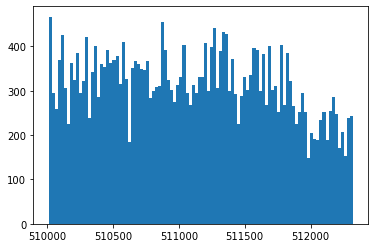

In [48]:
plt.hist(sip_train["NPLV"], bins=100);

In [52]:
feat_anal(sip_train["NPLV"])

min value = 510008
max value = 512322
value range = 2314


In [47]:
df = sip_train["NPLV"]

print(f"{df.name} уникален? ", df.is_unique)
print("Есть ли дубли в строках?", df.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((df.isnull().sum() > 0).sum()/len(df)*100))

NPLV уникален?  False
Есть ли дубли в строках? 29521
Сколько процент признаков могут принимать null-значениями? 0%


In [152]:
sip_test = pd.read_csv(path.joinpath('sip_test.csv'))
sip_test['DAT_OTD'] = sip_test['DAT_OTD'].apply(lambda x: pd.Timestamp(x))
sip_test

NPLV  VDSYP     NMSYP  VSSYP             DAT_OTD
0      512324    408   изв_ЦОИ   3020 2021-05-05 17:38:59
1      512324    442    ФЛЮМАГ   1670 2021-05-05 17:42:07
2      512324    408   изв_ЦОИ   2810 2021-05-05 17:42:07
3      512324    346  Уголь ТО    140 2021-05-05 17:43:39
4      512324    346  Уголь ТО     70 2021-05-05 17:43:49
...       ...    ...       ...    ...                 ...
10457  513374    346  Уголь ТО    630 2021-06-29 22:44:40
10458  513374    346  Уголь ТО   2310 2021-06-29 22:46:17
10459  513374    408   изв_ЦОИ  10010 2021-06-29 22:46:23
10460  513374    346  Уголь ТО    670 2021-06-29 22:48:22
10461  513374    408   изв_ЦОИ   1990 2021-06-29 23:07:10

[10462 rows x 5 columns]

In [228]:
sip_test[sip_test['DAT_OTD'] < '2021']

Empty DataFrame
Columns: [NPLV, VDSYP, NMSYP, VSSYP, DAT_OTD]
Index: []

In [153]:
sip_test.iloc[0,-1]

Timestamp('2021-05-05 17:38:59')

## target: целевые значения

- C	- содержание углерода в металле
- TST	- температура металла
- NPLV	- номер плавки

In [426]:
target_train = pd.read_csv(path.joinpath('target_train.csv'))
target_train

NPLV   TST      C
0     510008  1690  0.060
1     510009  1683  0.097
2     510010  1662  0.091
3     510011  1609  0.410
4     510012  1682  0.120
...      ...   ...    ...
2058  512318  1626  0.145
2059  512319  1643  0.087
2060  512320  1615  0.141
2061  512321  1654  0.270
2062  512322  1630  0.183

[2063 rows x 3 columns]

In [427]:
df = target_train["NPLV"]

print(f"{df.name} уникален? ", df.is_unique)
print("Есть ли дубли в строках?", df.duplicated().sum())
print("Сколько процент признаков могут принимать null-значениями? %d%%" % float((df.isnull().sum() > 0).sum()/len(df)*100))

NPLV уникален?  True
Есть ли дубли в строках? 0
Сколько процент признаков могут принимать null-значениями? 0%


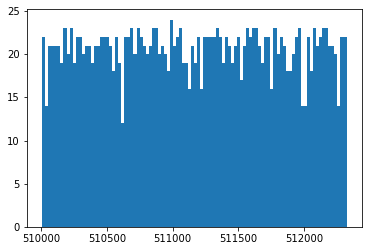

In [45]:
plt.hist(target_train["NPLV"], bins=100);

In [54]:
feat_anal(sip_train["NPLV"])

feat_anal(target_train["NPLV"])

min value = 510008
max value = 512322
value range = 2314
min value = 510008
max value = 512322
value range = 2314


# Идеи и выводы

- пропуски:
  - chronom_train имеет 15% пропусков
  - chronom_test 16%
  - targrt_train 2 пропущеных значения.

Идеи
- [ ] дропнуть 2011 год (всё что меньше 2021-го) `chronom_test[chronom_test['NPLV'] == 512324].sort_values(by='VR_NACH')`
- [ ] C - содержание углерода в металле - распределение скошенно - **логарифмировать**
- [ ] C - содержание углерода в металле - 2 пропущенных значения

# Baseline

## Анализ объединения на одной плавке

In [381]:
target_train[target_train['NPLV'] == 510008]

NPLV   TST     C
0  510008  1690  0.06

In [382]:
lom_train[lom_train['NPLV'] == 510008]

NPLV  VDL   NML    VES
0  510008    4  К     56500
1  510008    8  О     16700
2  510008   13  КП     3000

In [383]:
chugun_train[chugun_train['NPLV'] == 510008]

NPLV       VES       T    SI    MN      S      P    CR    NI    CU  \
0  510008  263700.0  1396.0  0.44  0.22  0.023  0.097  0.03  0.01  0.03   

       V     TI         DATA_ZAMERA  
0  0.103  0.084 2021-01-01 03:15:03

In [384]:
sip_train[sip_train['NPLV'] == 510008].sort_values(by='DAT_OTD')

NPLV  VDSYP      NMSYP  VSSYP             DAT_OTD
0   510008    346   Уголь ТО    570 2021-01-01 03:03:53
1   510008    346   Уголь ТО    220 2021-01-01 03:04:10
2   510008    408    изв_ЦОИ   7300 2021-01-01 03:08:17
3   510008    346   Уголь ТО    270 2021-01-01 03:09:03
4   510008    346   Уголь ТО    430 2021-01-01 03:09:20
5   510008    346   Уголь ТО   1460 2021-01-01 03:10:22
6   510008    408    изв_ЦОИ    810 2021-01-01 03:11:39
7   510008    171  Флюс ФОМИ    980 2021-01-01 03:11:39
8   510008    442     ФЛЮМАГ   2960 2021-01-01 03:14:36
9   510008    408    изв_ЦОИ   2010 2021-01-01 03:27:26
10  510008    408    изв_ЦОИ   1980 2021-01-01 03:30:19
11  510008    408    изв_ЦОИ   1980 2021-01-01 03:33:48

In [385]:
gas_train[gas_train['NPLV'] == 510008].sort_values(by='Time')

NPLV                    Time              V           T         O2  \
0     510008 2021-01-01 03:08:11.437  218263.343750  262.847229  18.722993   
1     510008 2021-01-01 03:08:12.437  218263.343750  262.847229  18.732721   
2     510008 2021-01-01 03:08:13.437  218369.359375  262.152771  18.742449   
3     510008 2021-01-01 03:08:14.437  218475.359375  261.805573  18.752177   
4     510008 2021-01-01 03:08:15.437  218369.359375  260.763885  18.761905   
...      ...                     ...            ...         ...        ...   
2555  510008 2021-01-01 03:51:06.437  218369.359375  131.944443   9.916870   
2556  510008 2021-01-01 03:51:07.437  219426.875000  131.944443   9.929288   
2557  510008 2021-01-01 03:51:08.437  219637.750000  131.944443   9.941707   
2558  510008 2021-01-01 03:51:09.437  219321.343750  131.944443   9.954125   
2559  510008 2021-01-01 03:51:10.437  219321.343750  131.944443   9.966543   

             N2        H2        CO2        CO        AR  T фурмы 1  \
0     80.132247  0.087755   0.163878  0.009229  0.893243        0.0   
1     80.138406  0.087959   0.148980  0.008390  0.892948        0.0   
2     80.144565  0.088163   0.134082  0.007551  0.892653        0.0   
3     80.150724  0.088367   0.119184  0.006712  0.892358        0.0   
4     80.156883  0.088571   0.104286  0.005873  0.892063        0.0   
...         ...       ...        ...       ...       ...        ...   
2555  78.370371  0.010074  10.185237  0.550623  0.973858        0.0   
2556  78.373759  0.010222  10.170386  0.549763  0.973769        0.0   
2557  78.377146  0.010370  10.155534  0.548902  0.973680        0.0   
2558  78.380534  0.010519  10.140683  0.548042  0.973591        0.0   
2559  78.383922  0.010667  10.125831  0.547181  0.973502        0.0   

      T фурмы 2  O2_pressure  
0           0.0    13.085938  
1           0.0    13.085938  
2           0.0    13.085938  
3           0.0    13.093172  
4           0.0    13.093172  
...         ...          ...  
2555        0.0    13.389757  
2556        0.0    13.389757  
2557        0.0    13.389757  
2558        0.0    13.389757  
2559        0.0    13.389757  

[2560 rows x 13 columns]

In [386]:
produv_train[produv_train['NPLV'] == 510008].sort_values(by='SEC')

NPLV                 SEC         RAS       POL
0     510008 2021-01-01 03:18:26  382.000000  3.920000
1     510008 2021-01-01 03:18:28  382.000000  3.920000
2     510008 2021-01-01 03:18:30  553.000000  3.920000
3     510008 2021-01-01 03:18:32  701.000000  3.920000
4     510008 2021-01-01 03:18:34  813.000000  3.920000
...      ...                 ...         ...       ...
2050  510008 2021-01-01 04:26:46  402.879076  3.542024
2051  510008 2021-01-01 04:26:48  403.103261  3.539620
2052  510008 2021-01-01 04:26:50  403.327446  3.537215
2053  510008 2021-01-01 04:26:52  403.551630  3.534810
2054  510008 2021-01-01 04:26:54  403.775815  3.532405

[2055 rows x 4 columns]

In [428]:
chronom_train[chronom_train['NPLV'] == 510008].sort_values(by='VR_NACH')

NPLV     TYPE_OPER                  NOP             VR_NACH  \
35162  510008  межпл.прост.       межпл. простой 2021-01-01 03:01:07   
35163  510008  межпл.прост.    Осмотр конвертера 2021-01-01 03:01:19   
35164  510008  межпл.прост.  Наведение гарнисажа 2021-01-01 03:03:43   
35165  510008  межпл.прост.           Слив шлака 2021-01-01 03:05:23   
35166  510008  межпл.прост.        Отсутствие O2 2021-01-01 03:06:09   
26     510008          опер         Завалка лома 2021-01-01 03:08:11   
27     510008          опер          Нагрев лома 2021-01-01 03:08:27   
33235  510008          опер          Нагрев лома 2021-01-01 03:08:27   
28     510008          опер       Заливка чугуна 2021-01-01 03:15:02   
29     510008          опер             Продувка 2021-01-01 03:18:25   
30     510008          опер              Повалка 2021-01-01 03:37:55   
69421  510008  вн.пл.прост.  Ожидание стальковша 2021-01-01 03:40:26   
31     510008          опер       Выпуск металла 2021-01-01 03:44:32   
32     510008          опер      Прерыв. выпуска 2021-01-01 03:50:10   
33     510008          опер           Слив шлака 2021-01-01 03:51:10   

                   VR_KON      O2  
35162 2021-01-01 03:08:11     NaN  
35163 2021-01-01 03:03:43     NaN  
35164 2021-01-01 03:05:23     NaN  
35165 2021-01-01 03:06:09     NaN  
35166 2021-01-01 03:08:15     NaN  
26    2021-01-01 03:08:27     NaN  
27    2021-01-01 03:14:32     NaN  
33235 2021-01-01 03:14:32  2909.0  
28    2021-01-01 03:18:25     NaN  
29    2021-01-01 03:37:55     NaN  
30    2021-01-01 03:44:32     NaN  
69421 2021-01-01 03:44:32     NaN  
31    2021-01-01 03:50:10     NaN  
32    2021-01-01 03:51:10     NaN  
33    2021-01-01 03:51:10     NaN

# Объединение датафреймов

## target_train + chugun_train

In [429]:
target_train = pd.merge(target_train, chugun_train, on='NPLV', how='inner')

In [430]:
print(target_train.shape)
target_train.head(3)

(2063, 15)


NPLV   TST      C       VES       T    SI    MN      S      P    CR  \
0  510008  1690  0.060  263700.0  1396.0  0.44  0.22  0.023  0.097  0.03   
1  510009  1683  0.097  264500.0  1419.0  0.68  0.20  0.017  0.087  0.02   
2  510010  1662  0.091  263800.0  1384.0  0.56  0.26  0.017  0.096  0.03   

     NI    CU      V     TI         DATA_ZAMERA  
0  0.01  0.03  0.103  0.084 2021-01-01 03:15:03  
1  0.01  0.03  0.084  0.096 2021-01-01 04:23:48  
2  0.01  0.03  0.115  0.110 2021-01-01 05:21:40

In [431]:
lom_train

NPLV  VDL   NML    VES
0     510008    4  К     56500
1     510008    8  О     16700
2     510008   13  КП     3000
3     510009    4  К     49800
4     510009    8  О     22800
...      ...  ...   ...    ...
6371  512321    8  О      4200
6372  512321   13  КП     3000
6373  512322    4  К     66700
6374  512322   13  КП     6000
6375  512322   48  У2КШ   3400

[6376 rows x 4 columns]

In [432]:
# список уникальных значений по категориальным фичам
for column in lom_train.columns[:-1]:
    print(f'{column}: {lom_train[column].unique()} \n')

NPLV: [510008 510009 510010 ... 512320 512321 512322] 

VDL: [ 4  8 13 23 61 20 48 49 63  3] 

NML: ['К   ' 'О   ' 'КП  ' 'ЛЧ  ' 'КШС8' 'ОК  ' 'У2КШ' '25КШ' 'СК  ' 'НБ  '] 



In [433]:
lom_train.shape

(6376, 4)

In [434]:
lom_train.head(7)

NPLV  VDL   NML    VES
0  510008    4  К     56500
1  510008    8  О     16700
2  510008   13  КП     3000
3  510009    4  К     49800
4  510009    8  О     22800
5  510009   13  КП     6000
6  510010    4  К     45900

In [435]:
lom_train[lom_train['NPLV'] == 512318]

NPLV  VDL   NML    VES
6358  512318    4  К     51700
6359  512318   13  КП     3000
6360  512318   23  ЛЧ    11500
6361  512318    8  О      3300
6362  512318   48  У2КШ   4100

In [436]:
# список уникальных значений по категориальным фичам
for column in lom_train.columns[:-1]:
    print(f'{column}: {lom_train[column].unique()} \n')

NPLV: [510008 510009 510010 ... 512320 512321 512322] 

VDL: [ 4  8 13 23 61 20 48 49 63  3] 

NML: ['К   ' 'О   ' 'КП  ' 'ЛЧ  ' 'КШС8' 'ОК  ' 'У2КШ' '25КШ' 'СК  ' 'НБ  '] 



## lom_train.pivot

In [437]:
# lom_train_pivot = lom_train.pivot_table(index=['NPLV'], columns=['VDL', 'NML'], values='VES', fill_value=0).reset_index()
# lom_train_pivot.columns = [(str(a) + '_' + str(b)) for a, b in lom_train_pivot.columns.tolist()]
# lom_train_pivot = lom_train_pivot.rename(columns={'NPLV_': 'NPLV'})
# print('DataFrame has MultiIndex:', isinstance(lom_train_pivot.index, pd.MultiIndex))
# lom_train_pivot

lom_train_pivot = lom_train.pivot(index='NPLV', columns=['VDL', 'NML'], values=['VES'])
lom_train_pivot.columns = [(str(a) + '_' + str(b) + '_' + str(c)) for a, b, c in lom_train_pivot.columns.tolist()]
lom_train_pivot.columns = lom_train_pivot.columns.str.replace(' ','')
lom_train_pivot = lom_train_pivot.fillna(0)
print('DataFrame has MultiIndex:', isinstance(lom_train_pivot.index, pd.MultiIndex))
lom_train_pivot

DataFrame has MultiIndex: False


VES_4_К  VES_8_О  VES_13_КП  VES_23_ЛЧ  VES_61_КШС8  VES_20_ОК  \
NPLV                                                                     
510008  56500.0  16700.0     3000.0        0.0          0.0        0.0   
510009  49800.0  22800.0     6000.0        0.0          0.0        0.0   
510010  45900.0  22400.0     2000.0     6000.0          0.0        0.0   
510011  51900.0  29200.0     3000.0        0.0          0.0        0.0   
510012  64000.0   6100.0     6000.0        0.0          0.0        0.0   
...         ...      ...        ...        ...          ...        ...   
512318  51700.0   3300.0     3000.0    11500.0          0.0        0.0   
512319  46400.0  15300.0     5000.0     9900.0          0.0        0.0   
512320  41400.0      0.0     5000.0        0.0          0.0        0.0   
512321  59000.0   4200.0     3000.0        0.0          0.0        0.0   
512322  66700.0      0.0     6000.0        0.0          0.0        0.0   

        VES_48_У2КШ  VES_49_25КШ  VES_63_СК  VES_3_НБ  
NPLV                                                   
510008          0.0          0.0        0.0       0.0  
510009          0.0          0.0        0.0       0.0  
510010          0.0          0.0        0.0       0.0  
510011          0.0          0.0        0.0       0.0  
510012          0.0          0.0        0.0       0.0  
...             ...          ...        ...       ...  
512318       4100.0          0.0        0.0       0.0  
512319          0.0          0.0        0.0       0.0  
512320      17800.0          0.0        0.0       0.0  
512321          0.0          0.0        0.0       0.0  
512322       3400.0          0.0        0.0       0.0  

[2063 rows x 10 columns]

## target_train + lom_train_pivot

In [438]:
target_train = pd.merge(target_train, lom_train_pivot, on='NPLV', how='inner')

In [439]:
target_train

NPLV   TST      C       VES       T    SI    MN      S      P    CR  \
0     510008  1690  0.060  263700.0  1396.0  0.44  0.22  0.023  0.097  0.03   
1     510009  1683  0.097  264500.0  1419.0  0.68  0.20  0.017  0.087  0.02   
2     510010  1662  0.091  263800.0  1384.0  0.56  0.26  0.017  0.096  0.03   
3     510011  1609  0.410  264000.0  1401.0  0.48  0.27  0.018  0.091  0.03   
4     510012  1682  0.120  263300.0  1422.0  0.47  0.23  0.018  0.096  0.02   
...      ...   ...    ...       ...     ...   ...   ...    ...    ...   ...   
2058  512318  1626  0.145  267200.0  1415.0  0.38  0.28  0.019  0.099  0.02   
2059  512319  1643  0.087  266800.0  1405.0  0.50  0.30  0.017  0.104  0.02   
2060  512320  1615  0.141  276100.0  1398.0  0.61  0.31  0.025  0.115  0.03   
2061  512321  1654  0.270  275800.0  1408.0  0.38  0.27  0.021  0.100  0.02   
2062  512322  1630  0.183  279200.0  1413.0  0.50  0.31  0.019  0.105  0.02   

      ...  VES_4_К  VES_8_О  VES_13_КП  VES_23_ЛЧ VES_61_КШС8  VES_20_ОК  \
0     ...  56500.0  16700.0     3000.0        0.0         0.0        0.0   
1     ...  49800.0  22800.0     6000.0        0.0         0.0        0.0   
2     ...  45900.0  22400.0     2000.0     6000.0         0.0        0.0   
3     ...  51900.0  29200.0     3000.0        0.0         0.0        0.0   
4     ...  64000.0   6100.0     6000.0        0.0         0.0        0.0   
...   ...      ...      ...        ...        ...         ...        ...   
2058  ...  51700.0   3300.0     3000.0    11500.0         0.0        0.0   
2059  ...  46400.0  15300.0     5000.0     9900.0         0.0        0.0   
2060  ...  41400.0      0.0     5000.0        0.0         0.0        0.0   
2061  ...  59000.0   4200.0     3000.0        0.0         0.0        0.0   
2062  ...  66700.0      0.0     6000.0        0.0         0.0        0.0   

      VES_48_У2КШ  VES_49_25КШ  VES_63_СК  VES_3_НБ  
0             0.0          0.0        0.0       0.0  
1             0.0          0.0        0.0       0.0  
2             0.0          0.0        0.0       0.0  
3             0.0          0.0        0.0       0.0  
4             0.0          0.0        0.0       0.0  
...           ...          ...        ...       ...  
2058       4100.0          0.0        0.0       0.0  
2059          0.0          0.0        0.0       0.0  
2060      17800.0          0.0        0.0       0.0  
2061          0.0          0.0        0.0       0.0  
2062       3400.0          0.0        0.0       0.0  

[2063 rows x 25 columns]

## lom_test.pivot

In [440]:
lom_test_pivot = lom_test.pivot(index='NPLV', columns=['VDL', 'NML'], values=['VES'])
lom_test_pivot.columns = [(str(a) + '_' + str(b) + '_' + str(c)) for a, b, c in lom_test_pivot.columns.tolist()]
lom_test_pivot.columns = lom_test_pivot.columns.str.replace(' ','')
lom_test_pivot = lom_test_pivot.fillna(0)
print('DataFrame has MultiIndex:', isinstance(lom_test_pivot.index, pd.MultiIndex))
lom_test_pivot

DataFrame has MultiIndex: False


VES_4_К  VES_8_О  VES_13_КП  VES_23_ЛЧ  VES_20_ОК  VES_49_25КШ  \
NPLV                                                                     
512324  26040.0  17660.0     2000.0        0.0        0.0          0.0   
512327  49400.0  10600.0     3000.0     8000.0        0.0          0.0   
512328  65700.0      0.0     6000.0        0.0        0.0          0.0   
512331  36000.0  32500.0     2000.0        0.0        0.0          0.0   
512333  40300.0  62200.0     2000.0        0.0        0.0          0.0   
...         ...      ...        ...        ...        ...          ...   
513369  52700.0   2300.0     6000.0        0.0        0.0          0.0   
513370  52700.0      0.0     3000.0        0.0        0.0          0.0   
513371  60100.0      0.0     6000.0     2000.0        0.0          0.0   
513372  59600.0   3100.0     3000.0        0.0        0.0          0.0   
513374  54400.0   9100.0     7000.0     2000.0        0.0          0.0   

        VES_61_КШС8  VES_48_У2КШ  VES_63_СК  
NPLV                                         
512324          0.0          0.0        0.0  
512327          0.0          0.0        0.0  
512328          0.0          0.0        0.0  
512331          0.0          0.0        0.0  
512333          0.0          0.0        0.0  
...             ...          ...        ...  
513369          0.0          0.0        0.0  
513370          0.0       6600.0        0.0  
513371          0.0          0.0        0.0  
513372          0.0        500.0        0.0  
513374          0.0          0.0        0.0  

[780 rows x 9 columns]

Проверяем на одинаковые столбцы

In [441]:
missed_columns = list(set(lom_train_pivot.columns) - set(lom_test_pivot.columns))
missed_columns

['VES_3_НБ']

Добавляем отстутсвующий столбец

In [442]:
lom_test_pivot[missed_columns] = 0

In [443]:
lom_test_pivot

VES_4_К  VES_8_О  VES_13_КП  VES_23_ЛЧ  VES_20_ОК  VES_49_25КШ  \
NPLV                                                                     
512324  26040.0  17660.0     2000.0        0.0        0.0          0.0   
512327  49400.0  10600.0     3000.0     8000.0        0.0          0.0   
512328  65700.0      0.0     6000.0        0.0        0.0          0.0   
512331  36000.0  32500.0     2000.0        0.0        0.0          0.0   
512333  40300.0  62200.0     2000.0        0.0        0.0          0.0   
...         ...      ...        ...        ...        ...          ...   
513369  52700.0   2300.0     6000.0        0.0        0.0          0.0   
513370  52700.0      0.0     3000.0        0.0        0.0          0.0   
513371  60100.0      0.0     6000.0     2000.0        0.0          0.0   
513372  59600.0   3100.0     3000.0        0.0        0.0          0.0   
513374  54400.0   9100.0     7000.0     2000.0        0.0          0.0   

        VES_61_КШС8  VES_48_У2КШ  VES_63_СК  VES_3_НБ  
NPLV                                                   
512324          0.0          0.0        0.0         0  
512327          0.0          0.0        0.0         0  
512328          0.0          0.0        0.0         0  
512331          0.0          0.0        0.0         0  
512333          0.0          0.0        0.0         0  
...             ...          ...        ...       ...  
513369          0.0          0.0        0.0         0  
513370          0.0       6600.0        0.0         0  
513371          0.0          0.0        0.0         0  
513372          0.0        500.0        0.0         0  
513374          0.0          0.0        0.0         0  

[780 rows x 10 columns]

## chugun_test + lom_test_pivot

In [444]:
test = pd.merge(chugun_test, lom_test_pivot, on='NPLV', how='inner')
print(test.shape)
test

(780, 23)


NPLV       VES       T    SI    MN      S      P    CR    NI    CU  \
0    512324  240100.0  1355.0  0.46  0.33  0.027  0.079  0.01  0.01  0.02   
1    512327  266400.0  1390.0  0.30  0.33  0.032  0.099  0.01  0.00  0.00   
2    512328  270200.0  1373.0  0.00  0.00  0.000  0.000  0.00  0.00  0.00   
3    512331  266700.0  1383.0  0.54  0.39  0.028  0.115  0.02  0.01  0.03   
4    512333  267400.0  1387.0  0.00  0.00  0.000  0.000  0.00  0.00  0.00   
..      ...       ...     ...   ...   ...    ...    ...   ...   ...   ...   
775  513369  280800.0  1324.0  0.35  0.29  0.035  0.096  0.01  0.01  0.02   
776  513370  280600.0  1389.0  0.39  0.31  0.024  0.097  0.01  0.01  0.02   
777  513371  279700.0  1332.0  0.30  0.27  0.031  0.099  0.01  0.01  0.02   
778  513372  279700.0  1378.0  0.43  0.33  0.026  0.113  0.01  0.01  0.02   
779  513374  270600.0  1396.0  0.36  0.33  0.026  0.104  0.02  0.01  0.02   

     ...  VES_4_К  VES_8_О VES_13_КП  VES_23_ЛЧ  VES_20_ОК  VES_49_25КШ  \
0    ...  26040.0  17660.0    2000.0        0.0        0.0          0.0   
1    ...  49400.0  10600.0    3000.0     8000.0        0.0          0.0   
2    ...  65700.0      0.0    6000.0        0.0        0.0          0.0   
3    ...  36000.0  32500.0    2000.0        0.0        0.0          0.0   
4    ...  40300.0  62200.0    2000.0        0.0        0.0          0.0   
..   ...      ...      ...       ...        ...        ...          ...   
775  ...  52700.0   2300.0    6000.0        0.0        0.0          0.0   
776  ...  52700.0      0.0    3000.0        0.0        0.0          0.0   
777  ...  60100.0      0.0    6000.0     2000.0        0.0          0.0   
778  ...  59600.0   3100.0    3000.0        0.0        0.0          0.0   
779  ...  54400.0   9100.0    7000.0     2000.0        0.0          0.0   

     VES_61_КШС8  VES_48_У2КШ  VES_63_СК  VES_3_НБ  
0            0.0          0.0        0.0         0  
1            0.0          0.0        0.0         0  
2            0.0          0.0        0.0         0  
3            0.0          0.0        0.0         0  
4            0.0          0.0        0.0         0  
..           ...          ...        ...       ...  
775          0.0          0.0        0.0         0  
776          0.0       6600.0        0.0         0  
777          0.0          0.0        0.0         0  
778          0.0        500.0        0.0         0  
779          0.0          0.0        0.0         0  

[780 rows x 23 columns]

In [445]:
list(set(target_train.columns) - set(test.columns))

['TST', 'C']

**Разница трейна и теста в 2-х стобцах - это таргеты**

In [446]:
test.head(2)

NPLV       VES       T    SI    MN      S      P    CR    NI    CU  ...  \
0  512324  240100.0  1355.0  0.46  0.33  0.027  0.079  0.01  0.01  0.02  ...   
1  512327  266400.0  1390.0  0.30  0.33  0.032  0.099  0.01  0.00  0.00  ...   

   VES_4_К  VES_8_О VES_13_КП  VES_23_ЛЧ  VES_20_ОК  VES_49_25КШ  VES_61_КШС8  \
0  26040.0  17660.0    2000.0        0.0        0.0          0.0          0.0   
1  49400.0  10600.0    3000.0     8000.0        0.0          0.0          0.0   

   VES_48_У2КШ  VES_63_СК  VES_3_НБ  
0          0.0        0.0         0  
1          0.0        0.0         0  

[2 rows x 23 columns]

In [447]:
target_train.head(2)

NPLV   TST      C       VES       T    SI    MN      S      P    CR  ...  \
0  510008  1690  0.060  263700.0  1396.0  0.44  0.22  0.023  0.097  0.03  ...   
1  510009  1683  0.097  264500.0  1419.0  0.68  0.20  0.017  0.087  0.02  ...   

   VES_4_К  VES_8_О  VES_13_КП  VES_23_ЛЧ VES_61_КШС8  VES_20_ОК  VES_48_У2КШ  \
0  56500.0  16700.0     3000.0        0.0         0.0        0.0          0.0   
1  49800.0  22800.0     6000.0        0.0         0.0        0.0          0.0   

   VES_49_25КШ  VES_63_СК  VES_3_НБ  
0          0.0        0.0       0.0  
1          0.0        0.0       0.0  

[2 rows x 25 columns]

In [448]:
target_train.columns

Index(['NPLV', 'TST', 'C', 'VES', 'T', 'SI', 'MN', 'S', 'P', 'CR', 'NI', 'CU',
       'V', 'TI', 'DATA_ZAMERA', 'VES_4_К', 'VES_8_О', 'VES_13_КП',
       'VES_23_ЛЧ', 'VES_61_КШС8', 'VES_20_ОК', 'VES_48_У2КШ', 'VES_49_25КШ',
       'VES_63_СК', 'VES_3_НБ'],
      dtype='object')

## chronom train + test - категориальные

In [513]:
chronom_train.head(2)

NPLV     TYPE_OPER                NOP             VR_NACH  \
35162  510008  межпл.прост.     межпл. простой 2021-01-01 03:01:07   
35163  510008  межпл.прост.  Осмотр конвертера 2021-01-01 03:01:19   

                   VR_KON  O2  
35162 2021-01-01 03:08:11 NaN  
35163 2021-01-01 03:03:43 NaN

In [518]:
# список уникальных значений по категориальным фичам
for column in ['TYPE_OPER', 'NOP']:
    print(f'{column}: {chronom_train[column].unique()} \n Кол-во уникальных: {chronom_train[column].nunique()} \n')

TYPE_OPER: ['межпл.прост.' 'опер' 'вн.пл.прост.'] 
 Кол-во уникальных: 3 

NOP: ['межпл. простой' 'Осмотр конвертера' 'Наведение гарнисажа' 'Слив шлака'
 'Отсутствие O2' 'Завалка лома' 'Нагрев лома' 'Заливка чугуна' 'Продувка'
 'Повалка' 'Ожидание стальковша' 'Выпуск металла' 'Прерыв. выпуска'
 'Вхождение в гр.МНЛЗ' 'Обрыв горловины' 'Додувка на t'
 'Наложение продувки' 'Охл. азотом' 'Подварка  футеровки'
 'Отсутствие чугуна' 'Отсечка шлака' 'Додувка на C' 'Неиспр. механ. обор.'
 'Неиспр. электр. обор' 'Ремонт летки' 'Замена фурмы'
 'Отсутствие мет.шихты' 'Полусухое торкрет.' 'ППР' 'Отсут. своб.разл.пл.'
 'Замер положения фурм' 'Ожидание шл.чаш' 'Неиспр. энерг. обор'
 'Скач. шлака'] 
 Кол-во уникальных: 34 



In [512]:
chronom_test.head(2)

NPLV     TYPE_OPER                NOP             VR_NACH  \
1  512324  межпл.прост.     межпл. простой 2021-05-05 17:35:55   
2  512324  межпл.прост.  Осмотр конвертера 2021-05-05 17:36:07   

               VR_KON  O2  
1 2021-05-05 17:41:21 NaN  
2 2021-05-05 17:39:07 NaN

In [519]:
# список уникальных значений по категориальным фичам
for column in ['TYPE_OPER', 'NOP']:
    print(f'{column}: {chronom_test[column].unique()} \n Кол-во уникальных: {chronom_test[column].nunique()} \n')

TYPE_OPER: ['межпл.прост.' 'опер' 'вн.пл.прост.'] 
 Кол-во уникальных: 3 

NOP: ['межпл. простой' 'Осмотр конвертера' 'Слив шлака' 'Завалка лома'
 'Нагрев лома' 'Наложение продувки' 'Заливка чугуна' 'Продувка'
 'Отсутствие чугуна' 'Обрыв горловины' 'Вхождение в гр.МНЛЗ'
 'Наведение гарнисажа' 'Замер положения фурм' 'Неиспр. электр. обор'
 'Замена фурмы' 'ППР' 'Ремонт летки' 'Отсут. своб.разл.пл.'
 'Отсутствие мет.шихты' 'Отсутствие O2' 'Ожидание шл.чаш'
 'Неиспр. механ. обор.' 'Неиспр. энерг. обор' 'Подварка  футеровки'
 'Подача чугуна' 'Полусухое торкрет.'] 
 Кол-во уникальных: 26 



Отличие в признаках трейна и теста

In [521]:
list(set(chronom_test['NOP'].unique()) - set(chronom_train['NOP'].unique()))

['Подача чугуна']

In [560]:
chronom = pd.concat([chronom_train, chronom_test], axis=0)
chronom

NPLV     TYPE_OPER                  NOP             VR_NACH  \
35162  510008  межпл.прост.       межпл. простой 2021-01-01 03:01:07   
35163  510008  межпл.прост.    Осмотр конвертера 2021-01-01 03:01:19   
35164  510008  межпл.прост.  Наведение гарнисажа 2021-01-01 03:03:43   
35165  510008  межпл.прост.           Слив шлака 2021-01-01 03:05:23   
35166  510008  межпл.прост.        Отсутствие O2 2021-01-01 03:06:09   
...       ...           ...                  ...                 ...   
7840   513374          опер         Завалка лома 2021-06-29 22:43:02   
7841   513374          опер          Нагрев лома 2021-06-29 22:43:54   
7842   513374          опер          Нагрев лома 2021-06-29 22:43:54   
7843   513374          опер       Заливка чугуна 2021-06-29 22:50:07   
7844   513374          опер             Продувка 2021-06-29 22:53:43   

                   VR_KON      O2  
35162 2021-01-01 03:08:11     NaN  
35163 2021-01-01 03:03:43     NaN  
35164 2021-01-01 03:05:23     NaN  
35165 2021-01-01 03:06:09     NaN  
35166 2021-01-01 03:08:15     NaN  
...                   ...     ...  
7840  2021-06-29 22:43:54     NaN  
7841  2021-06-29 22:49:59     NaN  
7842  2021-06-29 22:49:59  1797.0  
7843  2021-06-29 22:53:43     NaN  
7844  2021-06-29 23:13:47     NaN  

[38938 rows x 6 columns]

In [540]:
chronom[chronom['NPLV'] == 510008]

NPLV     TYPE_OPER                  NOP             VR_NACH  \
35162  510008  межпл.прост.       межпл. простой 2021-01-01 03:01:07   
35163  510008  межпл.прост.    Осмотр конвертера 2021-01-01 03:01:19   
35164  510008  межпл.прост.  Наведение гарнисажа 2021-01-01 03:03:43   
35165  510008  межпл.прост.           Слив шлака 2021-01-01 03:05:23   
35166  510008  межпл.прост.        Отсутствие O2 2021-01-01 03:06:09   
26     510008          опер         Завалка лома 2021-01-01 03:08:11   
27     510008          опер          Нагрев лома 2021-01-01 03:08:27   
33235  510008          опер          Нагрев лома 2021-01-01 03:08:27   
28     510008          опер       Заливка чугуна 2021-01-01 03:15:02   
29     510008          опер             Продувка 2021-01-01 03:18:25   
30     510008          опер              Повалка 2021-01-01 03:37:55   
69421  510008  вн.пл.прост.  Ожидание стальковша 2021-01-01 03:40:26   
31     510008          опер       Выпуск металла 2021-01-01 03:44:32   
32     510008          опер      Прерыв. выпуска 2021-01-01 03:50:10   
33     510008          опер           Слив шлака 2021-01-01 03:51:10   

                   VR_KON      O2  
35162 2021-01-01 03:08:11     NaN  
35163 2021-01-01 03:03:43     NaN  
35164 2021-01-01 03:05:23     NaN  
35165 2021-01-01 03:06:09     NaN  
35166 2021-01-01 03:08:15     NaN  
26    2021-01-01 03:08:27     NaN  
27    2021-01-01 03:14:32     NaN  
33235 2021-01-01 03:14:32  2909.0  
28    2021-01-01 03:18:25     NaN  
29    2021-01-01 03:37:55     NaN  
30    2021-01-01 03:44:32     NaN  
69421 2021-01-01 03:44:32     NaN  
31    2021-01-01 03:50:10     NaN  
32    2021-01-01 03:51:10     NaN  
33    2021-01-01 03:51:10     NaN

In [561]:
# удаляем типы операции ('межпл.прост.' и 'вн.пл.прост.')
chronom = chronom.drop(chronom[chronom['TYPE_OPER'] != 'опер'].index, axis=0)
# удаляем столбец типа операции
chronom = chronom.drop(['TYPE_OPER'], axis=1)
chronom

NPLV              NOP             VR_NACH              VR_KON      O2
33235  510008      Нагрев лома 2021-01-01 03:08:27 2021-01-01 03:14:32  2909.0
29     510008         Продувка 2021-01-01 03:18:25 2021-01-01 03:37:55     NaN
32     510008  Прерыв. выпуска 2021-01-01 03:50:10 2021-01-01 03:51:10     NaN
33     510008       Слив шлака 2021-01-01 03:51:10 2021-01-01 03:51:10     NaN
34     510009     Завалка лома 2021-01-01 04:00:44 2021-01-01 04:01:15     NaN
...       ...              ...                 ...                 ...     ...
7840   513374     Завалка лома 2021-06-29 22:43:02 2021-06-29 22:43:54     NaN
7841   513374      Нагрев лома 2021-06-29 22:43:54 2021-06-29 22:49:59     NaN
7842   513374      Нагрев лома 2021-06-29 22:43:54 2021-06-29 22:49:59  1797.0
7843   513374   Заливка чугуна 2021-06-29 22:50:07 2021-06-29 22:53:43     NaN
7844   513374         Продувка 2021-06-29 22:53:43 2021-06-29 23:13:47     NaN

[20696 rows x 5 columns]

In [562]:
# время операции в секундах
chronom['durat'] = (chronom['VR_KON'] - chronom['VR_NACH']).astype('timedelta64[s]')
chronom

NPLV              NOP             VR_NACH              VR_KON  \
33235  510008      Нагрев лома 2021-01-01 03:08:27 2021-01-01 03:14:32   
29     510008         Продувка 2021-01-01 03:18:25 2021-01-01 03:37:55   
32     510008  Прерыв. выпуска 2021-01-01 03:50:10 2021-01-01 03:51:10   
33     510008       Слив шлака 2021-01-01 03:51:10 2021-01-01 03:51:10   
34     510009     Завалка лома 2021-01-01 04:00:44 2021-01-01 04:01:15   
...       ...              ...                 ...                 ...   
7840   513374     Завалка лома 2021-06-29 22:43:02 2021-06-29 22:43:54   
7841   513374      Нагрев лома 2021-06-29 22:43:54 2021-06-29 22:49:59   
7842   513374      Нагрев лома 2021-06-29 22:43:54 2021-06-29 22:49:59   
7843   513374   Заливка чугуна 2021-06-29 22:50:07 2021-06-29 22:53:43   
7844   513374         Продувка 2021-06-29 22:53:43 2021-06-29 23:13:47   

           O2   durat  
33235  2909.0   365.0  
29        NaN  1170.0  
32        NaN    60.0  
33        NaN     0.0  
34        NaN    31.0  
...       ...     ...  
7840      NaN    52.0  
7841      NaN   365.0  
7842   1797.0   365.0  
7843      NaN   216.0  
7844      NaN  1204.0  

[20696 rows x 6 columns]

In [563]:
chronom = chronom.drop(['VR_NACH', 'VR_KON'], axis=1)
chronom

NPLV              NOP      O2   durat
33235  510008      Нагрев лома  2909.0   365.0
29     510008         Продувка     NaN  1170.0
32     510008  Прерыв. выпуска     NaN    60.0
33     510008       Слив шлака     NaN     0.0
34     510009     Завалка лома     NaN    31.0
...       ...              ...     ...     ...
7840   513374     Завалка лома     NaN    52.0
7841   513374      Нагрев лома     NaN   365.0
7842   513374      Нагрев лома  1797.0   365.0
7843   513374   Заливка чугуна     NaN   216.0
7844   513374         Продувка     NaN  1204.0

[20696 rows x 4 columns]

In [576]:
chronom[chronom['NPLV'] < 510011]

NPLV              NOP      O2   durat
33235  510008      Нагрев лома  2909.0   365.0
29     510008         Продувка     NaN  1170.0
32     510008  Прерыв. выпуска     NaN    60.0
33     510008       Слив шлака     NaN     0.0
34     510009     Завалка лома     NaN    31.0
33236  510009      Нагрев лома  2182.0   394.0
37     510009         Продувка     NaN  1230.0
39     510009   Выпуск металла     NaN   335.0
40     510009  Прерыв. выпуска     NaN    60.0
41     510009       Слив шлака     NaN     0.0
33237  510010      Нагрев лома  2841.0   369.0
47     510010   Выпуск металла     NaN   313.0
49     510010       Слив шлака     NaN     0.0

In [575]:
chronom_pivot = chronom.pivot_table(index=['NPLV'], columns=['NOP'], values=['O2', 'durat'], fill_value=0)
chronom_pivot = chronom_pivot.reset_index()
chronom_pivot.columns = [(str(a) + '_' + str(b)) for a, b in chronom_pivot.columns.tolist()]
chronom_pivot = chronom_pivot.rename(columns={'NPLV_': 'NPLV'})
print('DataFrame has MultiIndex:', isinstance(chronom_pivot.index, pd.MultiIndex))
chronom_pivot[chronom_pivot['NPLV'] < 510012]

DataFrame has MultiIndex: False


NPLV  O2_Выпуск металла  O2_Додувка на C  O2_Додувка на t  \
0  510008                  0              0.0              0.0   
1  510009                  0              0.0              0.0   
2  510010                  0              0.0              0.0   
3  510011                  0              0.0              0.0   

   O2_Завалка лома  O2_Заливка чугуна  O2_Нагрев лома  O2_Отсечка шлака  \
0                0                  0          2909.0                 0   
1                0                  0          2182.0                 0   
2                0                  0          2841.0                 0   
3                0                  0            10.0                 0   

   O2_Охл. азотом  O2_Повалка  ...  durat_Завалка лома  durat_Заливка чугуна  \
0               0           0  ...                   0                     0   
1               0           0  ...                  31                     0   
2               0           0  ...                   0                     0   
3               0           0  ...                  17                     0   

   durat_Нагрев лома  durat_Отсечка шлака  durat_Охл. азотом  durat_Повалка  \
0              365.0                    0                0.0            0.0   
1              394.0                    0                0.0            0.0   
2              369.0                    0                0.0            0.0   
3              388.0                    0                0.0          495.0   

   durat_Прерыв. выпуска  durat_Продувка  durat_Скач. шлака  durat_Слив шлака  
0                     60            1170                  0                 0  
1                     60            1230                  0                 0  
2                      0               0                  0                 0  
3                     60               0                  0                 0  

[4 rows x 27 columns]

## Делим chronom на трейн и тест

In [582]:
chronom_pivot.shape

(2843, 27)

In [578]:
chronom_train['NPLV'].min(), chronom_train['NPLV'].max(), chronom_test['NPLV'].min(), chronom_test['NPLV'].max()

(510008, 512322, 512324, 513374)

In [581]:
chronom_train = chronom_pivot[chronom_pivot['NPLV'] < 512323]
chronom_train

NPLV  O2_Выпуск металла  O2_Додувка на C  O2_Додувка на t  \
0     510008                  0              0.0              0.0   
1     510009                  0              0.0              0.0   
2     510010                  0              0.0              0.0   
3     510011                  0              0.0              0.0   
4     510012                  0              0.0           1094.0   
...      ...                ...              ...              ...   
2058  512318                  0              0.0           1917.0   
2059  512319                  0           1660.0              0.0   
2060  512320                  0              0.0              0.0   
2061  512321                  0            371.0              0.0   
2062  512322                  0              0.0              0.0   

      O2_Завалка лома  O2_Заливка чугуна  O2_Нагрев лома  O2_Отсечка шлака  \
0                   0                  0          2909.0                 0   
1                   0                  0          2182.0                 0   
2                   0                  0          2841.0                 0   
3                   0                  0            10.0                 0   
4                   0                  0          2131.0                 0   
...               ...                ...             ...               ...   
2058                0                  0             0.0                 0   
2059                0                  0             0.0                 0   
2060                0                  0             0.0                 0   
2061                0                  0             0.0                 0   
2062                0                  0           665.0                 0   

      O2_Охл. азотом  O2_Повалка  ...  durat_Завалка лома  \
0                  0           0  ...                   0   
1                  0           0  ...                  31   
2                  0           0  ...                   0   
3                  0           0  ...                  17   
4                  0           0  ...                   0   
...              ...         ...  ...                 ...   
2058               0           0  ...                 102   
2059               0           0  ...                1415   
2060               0           0  ...                 534   
2061               0           0  ...                 645   
2062               0           0  ...                2446   

      durat_Заливка чугуна  durat_Нагрев лома  durat_Отсечка шлака  \
0                        0              365.0                    0   
1                        0              394.0                    0   
2                        0              369.0                    0   
3                        0              388.0                    0   
4                        0              368.0                    0   
...                    ...                ...                  ...   
2058                   242                0.0                    0   
2059                   224                0.0                    0   
2060                   315                0.0                    0   
2061                   160                0.0                    0   
2062                   138               38.0                    0   

      durat_Охл. азотом  durat_Повалка  durat_Прерыв. выпуска  durat_Продувка  \
0                   0.0            0.0                     60            1170   
1                   0.0            0.0                     60            1230   
2                   0.0            0.0                      0               0   
3                   0.0          495.0                     60               0   
4                   0.0          233.0                      0            1239   
...                 ...            ...                    ...             ...   
2058                0.0          592.5                     40            1063   
2059                

In [583]:
chronom_test = chronom_pivot[chronom_pivot['NPLV'] > 512323]
chronom_test

NPLV  O2_Выпуск металла  O2_Додувка на C  O2_Додувка на t  \
2063  512324                  0              0.0              0.0   
2064  512327                  0              0.0              0.0   
2065  512328                  0              0.0              0.0   
2066  512331                  0              0.0              0.0   
2067  512333                  0              0.0              0.0   
...      ...                ...              ...              ...   
2838  513369                  0              0.0              0.0   
2839  513370                  0              0.0              0.0   
2840  513371                  0              0.0              0.0   
2841  513372                  0              0.0              0.0   
2842  513374                  0              0.0              0.0   

      O2_Завалка лома  O2_Заливка чугуна  O2_Нагрев лома  O2_Отсечка шлака  \
2063                0                  0          1452.0                 0   
2064                0                  0             0.0                 0   
2065                0                  0             0.0                 0   
2066                0                  0             0.0                 0   
2067                0                  0             0.0                 0   
...               ...                ...             ...               ...   
2838                0                  0          2433.0                 0   
2839                0                  0          2232.0                 0   
2840                0                  0          1904.0                 0   
2841                0                  0             0.0                 0   
2842                0                  0          1797.0                 0   

      O2_Охл. азотом  O2_Повалка  ...  durat_Завалка лома  \
2063               0           0  ...                 115   
2064               0           0  ...                 114   
2065               0           0  ...                2096   
2066               0           0  ...                3015   
2067               0           0  ...                1478   
...              ...         ...  ...                 ...   
2838               0           0  ...                 225   
2839               0           0  ...                 158   
2840               0           0  ...                 131   
2841               0           0  ...                 105   
2842               0           0  ...                  52   

      durat_Заливка чугуна  durat_Нагрев лома  durat_Отсечка шлака  \
2063                   143              365.0                    0   
2064                   578                0.0                    0   
2065                   150                0.0                    0   
2066                   221                0.0                    0   
2067                   199                0.0                    0   
...                    ...                ...                  ...   
2838                   289              366.0                    0   
2839                   371              373.0                    0   
2840                   356              368.0                    0   
2841                   174                0.0                    0   
2842                   216              365.0                    0   

      durat_Охл. азотом  durat_Повалка  durat_Прерыв. выпуска  durat_Продувка  \
2063                0.0            0.0                      0            1263   
2064                0.0            0.0                      0            1074   
2065                0.0            0.0                      0            1122   
2066                0.0            0.0                      0            1103   
2067                0.0            0.0                      0            1096   
...                 ...            ...                    ...             ...   
2838                0.0            0.0                      0            1213   
2839                

## target_train + chronom_train (pivoted)

In [584]:
target_train

NPLV   TST      C       VES       T    SI    MN      S      P    CR  \
0     510008  1690  0.060  263700.0  1396.0  0.44  0.22  0.023  0.097  0.03   
1     510009  1683  0.097  264500.0  1419.0  0.68  0.20  0.017  0.087  0.02   
2     510010  1662  0.091  263800.0  1384.0  0.56  0.26  0.017  0.096  0.03   
3     510011  1609  0.410  264000.0  1401.0  0.48  0.27  0.018  0.091  0.03   
4     510012  1682  0.120  263300.0  1422.0  0.47  0.23  0.018  0.096  0.02   
...      ...   ...    ...       ...     ...   ...   ...    ...    ...   ...   
2058  512318  1626  0.145  267200.0  1415.0  0.38  0.28  0.019  0.099  0.02   
2059  512319  1643  0.087  266800.0  1405.0  0.50  0.30  0.017  0.104  0.02   
2060  512320  1615  0.141  276100.0  1398.0  0.61  0.31  0.025  0.115  0.03   
2061  512321  1654  0.270  275800.0  1408.0  0.38  0.27  0.021  0.100  0.02   
2062  512322  1630  0.183  279200.0  1413.0  0.50  0.31  0.019  0.105  0.02   

      ...  VES_4_К  VES_8_О  VES_13_КП  VES_23_ЛЧ VES_61_КШС8  VES_20_ОК  \
0     ...  56500.0  16700.0     3000.0        0.0         0.0        0.0   
1     ...  49800.0  22800.0     6000.0        0.0         0.0        0.0   
2     ...  45900.0  22400.0     2000.0     6000.0         0.0        0.0   
3     ...  51900.0  29200.0     3000.0        0.0         0.0        0.0   
4     ...  64000.0   6100.0     6000.0        0.0         0.0        0.0   
...   ...      ...      ...        ...        ...         ...        ...   
2058  ...  51700.0   3300.0     3000.0    11500.0         0.0        0.0   
2059  ...  46400.0  15300.0     5000.0     9900.0         0.0        0.0   
2060  ...  41400.0      0.0     5000.0        0.0         0.0        0.0   
2061  ...  59000.0   4200.0     3000.0        0.0         0.0        0.0   
2062  ...  66700.0      0.0     6000.0        0.0         0.0        0.0   

      VES_48_У2КШ  VES_49_25КШ  VES_63_СК  VES_3_НБ  
0             0.0          0.0        0.0       0.0  
1             0.0          0.0        0.0       0.0  
2             0.0          0.0        0.0       0.0  
3             0.0          0.0        0.0       0.0  
4             0.0          0.0        0.0       0.0  
...           ...          ...        ...       ...  
2058       4100.0          0.0        0.0       0.0  
2059          0.0          0.0        0.0       0.0  
2060      17800.0          0.0        0.0       0.0  
2061          0.0          0.0        0.0       0.0  
2062       3400.0          0.0        0.0       0.0  

[2063 rows x 25 columns]

In [585]:
target_train = pd.merge(target_train, chronom_train, on='NPLV', how='inner')

In [586]:
target_train

NPLV   TST      C       VES       T    SI    MN      S      P    CR  \
0     510008  1690  0.060  263700.0  1396.0  0.44  0.22  0.023  0.097  0.03   
1     510009  1683  0.097  264500.0  1419.0  0.68  0.20  0.017  0.087  0.02   
2     510010  1662  0.091  263800.0  1384.0  0.56  0.26  0.017  0.096  0.03   
3     510011  1609  0.410  264000.0  1401.0  0.48  0.27  0.018  0.091  0.03   
4     510012  1682  0.120  263300.0  1422.0  0.47  0.23  0.018  0.096  0.02   
...      ...   ...    ...       ...     ...   ...   ...    ...    ...   ...   
2058  512318  1626  0.145  267200.0  1415.0  0.38  0.28  0.019  0.099  0.02   
2059  512319  1643  0.087  266800.0  1405.0  0.50  0.30  0.017  0.104  0.02   
2060  512320  1615  0.141  276100.0  1398.0  0.61  0.31  0.025  0.115  0.03   
2061  512321  1654  0.270  275800.0  1408.0  0.38  0.27  0.021  0.100  0.02   
2062  512322  1630  0.183  279200.0  1413.0  0.50  0.31  0.019  0.105  0.02   

      ...  durat_Завалка лома  durat_Заливка чугуна  durat_Нагрев лома  \
0     ...                   0                     0              365.0   
1     ...                  31                     0              394.0   
2     ...                   0                     0              369.0   
3     ...                  17                     0              388.0   
4     ...                   0                     0              368.0   
...   ...                 ...                   ...                ...   
2058  ...                 102                   242                0.0   
2059  ...                1415                   224                0.0   
2060  ...                 534                   315                0.0   
2061  ...                 645                   160                0.0   
2062  ...                2446                   138               38.0   

      durat_Отсечка шлака durat_Охл. азотом  durat_Повалка  \
0                       0               0.0            0.0   
1                       0               0.0            0.0   
2                       0               0.0            0.0   
3                       0               0.0          495.0   
4                       0               0.0          233.0   
...                   ...               ...            ...   
2058                    0               0.0          592.5   
2059                    0               0.0          295.0   
2060                    0               0.0          438.5   
2061                    0               0.0          584.5   
2062                    0               0.0          584.0   

      durat_Прерыв. выпуска  durat_Продувка  durat_Скач. шлака  \
0                        60            1170                  0   
1                        60            1230                  0   
2                         0               0                  0   
3                        60               0                  0   
4                         0            1239                  0   
...                     ...             ...                ...   
2058                     40            1063                  0   
2059                     60            1108                  0   
2060                     42            1058                  0   
2061                     54            1169                  0   
2062                     60            1208                  0   

      durat_Слив шлака  
0                    0  
1                    0  
2                    0  
3                    0  
4                    0  
...                ...  
2058                20  
2059                 0  
2060                18  
2061                 6  
2062                 0  

[2063 rows x 51 columns]

## test + chronom_test (pivoted)

In [587]:
test

NPLV       VES       T    SI    MN      S      P    CR    NI    CU  \
0    512324  240100.0  1355.0  0.46  0.33  0.027  0.079  0.01  0.01  0.02   
1    512327  266400.0  1390.0  0.30  0.33  0.032  0.099  0.01  0.00  0.00   
2    512328  270200.0  1373.0  0.00  0.00  0.000  0.000  0.00  0.00  0.00   
3    512331  266700.0  1383.0  0.54  0.39  0.028  0.115  0.02  0.01  0.03   
4    512333  267400.0  1387.0  0.00  0.00  0.000  0.000  0.00  0.00  0.00   
..      ...       ...     ...   ...   ...    ...    ...   ...   ...   ...   
775  513369  280800.0  1324.0  0.35  0.29  0.035  0.096  0.01  0.01  0.02   
776  513370  280600.0  1389.0  0.39  0.31  0.024  0.097  0.01  0.01  0.02   
777  513371  279700.0  1332.0  0.30  0.27  0.031  0.099  0.01  0.01  0.02   
778  513372  279700.0  1378.0  0.43  0.33  0.026  0.113  0.01  0.01  0.02   
779  513374  270600.0  1396.0  0.36  0.33  0.026  0.104  0.02  0.01  0.02   

     ...  VES_4_К  VES_8_О VES_13_КП  VES_23_ЛЧ  VES_20_ОК  VES_49_25КШ  \
0    ...  26040.0  17660.0    2000.0        0.0        0.0          0.0   
1    ...  49400.0  10600.0    3000.0     8000.0        0.0          0.0   
2    ...  65700.0      0.0    6000.0        0.0        0.0          0.0   
3    ...  36000.0  32500.0    2000.0        0.0        0.0          0.0   
4    ...  40300.0  62200.0    2000.0        0.0        0.0          0.0   
..   ...      ...      ...       ...        ...        ...          ...   
775  ...  52700.0   2300.0    6000.0        0.0        0.0          0.0   
776  ...  52700.0      0.0    3000.0        0.0        0.0          0.0   
777  ...  60100.0      0.0    6000.0     2000.0        0.0          0.0   
778  ...  59600.0   3100.0    3000.0        0.0        0.0          0.0   
779  ...  54400.0   9100.0    7000.0     2000.0        0.0          0.0   

     VES_61_КШС8  VES_48_У2КШ  VES_63_СК  VES_3_НБ  
0            0.0          0.0        0.0         0  
1            0.0          0.0        0.0         0  
2            0.0          0.0        0.0         0  
3            0.0          0.0        0.0         0  
4            0.0          0.0        0.0         0  
..           ...          ...        ...       ...  
775          0.0          0.0        0.0         0  
776          0.0       6600.0        0.0         0  
777          0.0          0.0        0.0         0  
778          0.0        500.0        0.0         0  
779          0.0          0.0        0.0         0  

[780 rows x 23 columns]

In [588]:
test = pd.merge(test, chronom_test, on='NPLV', how='inner')

In [589]:
test

NPLV       VES       T    SI    MN      S      P    CR    NI    CU  \
0    512324  240100.0  1355.0  0.46  0.33  0.027  0.079  0.01  0.01  0.02   
1    512327  266400.0  1390.0  0.30  0.33  0.032  0.099  0.01  0.00  0.00   
2    512328  270200.0  1373.0  0.00  0.00  0.000  0.000  0.00  0.00  0.00   
3    512331  266700.0  1383.0  0.54  0.39  0.028  0.115  0.02  0.01  0.03   
4    512333  267400.0  1387.0  0.00  0.00  0.000  0.000  0.00  0.00  0.00   
..      ...       ...     ...   ...   ...    ...    ...   ...   ...   ...   
775  513369  280800.0  1324.0  0.35  0.29  0.035  0.096  0.01  0.01  0.02   
776  513370  280600.0  1389.0  0.39  0.31  0.024  0.097  0.01  0.01  0.02   
777  513371  279700.0  1332.0  0.30  0.27  0.031  0.099  0.01  0.01  0.02   
778  513372  279700.0  1378.0  0.43  0.33  0.026  0.113  0.01  0.01  0.02   
779  513374  270600.0  1396.0  0.36  0.33  0.026  0.104  0.02  0.01  0.02   

     ...  durat_Завалка лома  durat_Заливка чугуна durat_Нагрев лома  \
0    ...                 115                   143             365.0   
1    ...                 114                   578               0.0   
2    ...                2096                   150               0.0   
3    ...                3015                   221               0.0   
4    ...                1478                   199               0.0   
..   ...                 ...                   ...               ...   
775  ...                 225                   289             366.0   
776  ...                 158                   371             373.0   
777  ...                 131                   356             368.0   
778  ...                 105                   174               0.0   
779  ...                  52                   216             365.0   

     durat_Отсечка шлака  durat_Охл. азотом  durat_Повалка  \
0                      0                0.0            0.0   
1                      0                0.0            0.0   
2                      0                0.0            0.0   
3                      0                0.0            0.0   
4                      0                0.0            0.0   
..                   ...                ...            ...   
775                    0                0.0            0.0   
776                    0                0.0            0.0   
777                    0                0.0            0.0   
778                    0                0.0            0.0   
779                    0                0.0            0.0   

     durat_Прерыв. выпуска  durat_Продувка  durat_Скач. шлака  \
0                        0            1263                  0   
1                        0            1074                  0   
2                        0            1122                  0   
3                        0            1103                  0   
4                        0            1096                  0   
..                     ...             ...                ...   
775                      0            1213                  0   
776                      0            1161                  0   
777                      0            1181                  0   
778                      0            1335                  0   
779                      0            1204                  0   

     durat_Слив шлака  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
..                ...  
775                 0  
776                 0  
777                 0  
778                 0  
779                 0  

[780 rows x 49 columns]

# Baseline

In [ ]:
ridge = Ridge(random_state=42)
train_model(ridge, X_train_scale, y_train, X_valid_scale, y_valid, X.columns)
ridge_cv = RidgeCV()
train_model(ridge_cv, X_train_scale, y_train, X_valid_scale, y_valid, X.columns)

model = LinearRegression()
scaler = StandardScaler()

In [420]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_valid, y_train, y_valid = train_test_split(target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1),
                                                      target_train['TST'], 
                                                      test_size=0.3, 
                                                      random_state=18)

scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_valid_scale = scaler.transform(X_valid)


def train_model(model, X_train, y_train, X_valid, y_valid, feature_names):
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    
    print("RMSE: {}".format(np.sqrt(mean_squared_error((y_valid), (y_pred)))))
    
    print("metric: {}".format(np.sqrt(mean_squared_error((y_valid), (y_pred)))))
    
    print(pd.DataFrame(model.coef_, index=feature_names, 
                       columns=['weight']).sort_values(by='weight', ascending=False))
    

ridge = Ridge(random_state=42)
train_model(ridge, X_train_scale, y_train, X_valid_scale, y_valid, X_train.columns)

RMSE: 32.64319870157134
               weight
MN           8.780642
TI           5.304076
T            4.150308
VES_4_К      3.944452
VES_13_КП    2.584317
NPLV         1.238518
VES_23_ЛЧ    1.168950
VES_20_ОК    1.128110
VES_8_О      0.664519
VES_61_КШС8  0.233230
VES_3_НБ     0.083715
CU          -0.014441
VES_63_СК   -0.305574
NI          -0.976899
VES_48_У2КШ -1.004682
VES_49_25КШ -1.435463
CR          -1.671477
S           -1.916837
P           -2.521568
VES         -3.099244
SI          -4.200971
V           -5.351796


In [450]:
target_train.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1)

NPLV       VES       T    SI    MN      S      P    CR    NI    CU  \
0     510008  263700.0  1396.0  0.44  0.22  0.023  0.097  0.03  0.01  0.03   
1     510009  264500.0  1419.0  0.68  0.20  0.017  0.087  0.02  0.01  0.03   
2     510010  263800.0  1384.0  0.56  0.26  0.017  0.096  0.03  0.01  0.03   
3     510011  264000.0  1401.0  0.48  0.27  0.018  0.091  0.03  0.01  0.02   
4     510012  263300.0  1422.0  0.47  0.23  0.018  0.096  0.02  0.01  0.03   
...      ...       ...     ...   ...   ...    ...    ...   ...   ...   ...   
2058  512318  267200.0  1415.0  0.38  0.28  0.019  0.099  0.02  0.01  0.02   
2059  512319  266800.0  1405.0  0.50  0.30  0.017  0.104  0.02  0.01  0.02   
2060  512320  276100.0  1398.0  0.61  0.31  0.025  0.115  0.03  0.01  0.03   
2061  512321  275800.0  1408.0  0.38  0.27  0.021  0.100  0.02  0.01  0.03   
2062  512322  279200.0  1413.0  0.50  0.31  0.019  0.105  0.02  0.01  0.03   

      ...  VES_4_К  VES_8_О  VES_13_КП  VES_23_ЛЧ  VES_61_КШС8  VES_20_ОК  \
0     ...  56500.0  16700.0     3000.0        0.0          0.0        0.0   
1     ...  49800.0  22800.0     6000.0        0.0          0.0        0.0   
2     ...  45900.0  22400.0     2000.0     6000.0          0.0        0.0   
3     ...  51900.0  29200.0     3000.0        0.0          0.0        0.0   
4     ...  64000.0   6100.0     6000.0        0.0          0.0        0.0   
...   ...      ...      ...        ...        ...          ...        ...   
2058  ...  51700.0   3300.0     3000.0    11500.0          0.0        0.0   
2059  ...  46400.0  15300.0     5000.0     9900.0          0.0        0.0   
2060  ...  41400.0      0.0     5000.0        0.0          0.0        0.0   
2061  ...  59000.0   4200.0     3000.0        0.0          0.0        0.0   
2062  ...  66700.0      0.0     6000.0        0.0          0.0        0.0   

      VES_48_У2КШ  VES_49_25КШ  VES_63_СК  VES_3_НБ  
0             0.0          0.0        0.0       0.0  
1             0.0          0.0        0.0       0.0  
2             0.0          0.0        0.0       0.0  
3             0.0          0.0        0.0       0.0  
4             0.0          0.0        0.0       0.0  
...           ...          ...        ...       ...  
2058       4100.0          0.0        0.0       0.0  
2059          0.0          0.0        0.0       0.0  
2060      17800.0          0.0        0.0       0.0  
2061          0.0          0.0        0.0       0.0  
2062       3400.0          0.0        0.0       0.0  

[2063 rows x 22 columns]

In [ ]:
from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV

scaler = StandardScaler()

# обозначим один из шагов пайплайна как log_reg
step_ridge = ('ridge', Ridge(random_state=42))

bl_estimator = Pipeline([
    step_ridge
])

kfold_cv = KFold(n_splits=5, shuffle=True, random_state=42)

def run_cv(estimator, cv, df, scoring='roc_auc', model_name=""):
    
    X = df.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1)

    y1 = df['TST']
    y2 = df['C']
    
    X_scale = scaler.fit_transform(X)
    
    # расчёт метрики на кросс-валидации
    cv_res = cross_validate(estimator, X_scale, y1, cv=cv, scoring=scoring, n_jobs=-1)
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                          scoring,
                                          cv_res['test_score'].mean(),
                                          cv_res['test_score'].std() * 2))
    
    cv_res = cross_validate(estimator, X_scale, y2, cv=cv, scoring=scoring, n_jobs=-1)
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                          scoring,
                                          cv_res['test_score'].mean(),
                                          cv_res['test_score'].std() * 2))


run_cv(bl_estimator, kfold_cv, target_train, scoring=metric, model_name="Baseline");

In [421]:
lgb_params = { 
#     'boosting_type': 'gbdt',
#     'n_estimators': 10000,
#     'learning_rate': 0.05134, # default = 0.1, constraints: learning_rate > 0.0
#     'num_leaves': 10, # default = 31
#     'min_data_in_leaf':10000, # default = 20
#     'feature_fraction':0.1, # default = 1.0, constraints: 0.0 < feature_fraction <= 1.0
#     'max_depth': 10,
#     'subsample_for_bin': 240000,
#     'lambda_l1': 2,
#     'lambda_l2': 0,
#     'colsample_bytree': 0.508716,
#     'min_split_gain': 0.024766,
#     'subsample': 0.7,
#     'is_unbalance': False,
     'random_state': 27,
     'silent': -1,
     'verbose': -1
}

In [462]:
target_train

NPLV   TST      C       VES       T    SI    MN      S      P    CR  \
0     510008  1690  0.060  263700.0  1396.0  0.44  0.22  0.023  0.097  0.03   
1     510009  1683  0.097  264500.0  1419.0  0.68  0.20  0.017  0.087  0.02   
2     510010  1662  0.091  263800.0  1384.0  0.56  0.26  0.017  0.096  0.03   
3     510011  1609  0.410  264000.0  1401.0  0.48  0.27  0.018  0.091  0.03   
4     510012  1682  0.120  263300.0  1422.0  0.47  0.23  0.018  0.096  0.02   
...      ...   ...    ...       ...     ...   ...   ...    ...    ...   ...   
2058  512318  1626  0.145  267200.0  1415.0  0.38  0.28  0.019  0.099  0.02   
2059  512319  1643  0.087  266800.0  1405.0  0.50  0.30  0.017  0.104  0.02   
2060  512320  1615  0.141  276100.0  1398.0  0.61  0.31  0.025  0.115  0.03   
2061  512321  1654  0.270  275800.0  1408.0  0.38  0.27  0.021  0.100  0.02   
2062  512322  1630  0.183  279200.0  1413.0  0.50  0.31  0.019  0.105  0.02   

      ...  VES_4_К  VES_8_О  VES_13_КП  VES_23_ЛЧ VES_61_КШС8  VES_20_ОК  \
0     ...  56500.0  16700.0     3000.0        0.0         0.0        0.0   
1     ...  49800.0  22800.0     6000.0        0.0         0.0        0.0   
2     ...  45900.0  22400.0     2000.0     6000.0         0.0        0.0   
3     ...  51900.0  29200.0     3000.0        0.0         0.0        0.0   
4     ...  64000.0   6100.0     6000.0        0.0         0.0        0.0   
...   ...      ...      ...        ...        ...         ...        ...   
2058  ...  51700.0   3300.0     3000.0    11500.0         0.0        0.0   
2059  ...  46400.0  15300.0     5000.0     9900.0         0.0        0.0   
2060  ...  41400.0      0.0     5000.0        0.0         0.0        0.0   
2061  ...  59000.0   4200.0     3000.0        0.0         0.0        0.0   
2062  ...  66700.0      0.0     6000.0        0.0         0.0        0.0   

      VES_48_У2КШ  VES_49_25КШ  VES_63_СК  VES_3_НБ  
0             0.0          0.0        0.0       0.0  
1             0.0          0.0        0.0       0.0  
2             0.0          0.0        0.0       0.0  
3             0.0          0.0        0.0       0.0  
4             0.0          0.0        0.0       0.0  
...           ...          ...        ...       ...  
2058       4100.0          0.0        0.0       0.0  
2059          0.0          0.0        0.0       0.0  
2060      17800.0          0.0        0.0       0.0  
2061          0.0          0.0        0.0       0.0  
2062       3400.0          0.0        0.0       0.0  

[2063 rows x 25 columns]

In [466]:
target_train_1 = target_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
target_train_1.columns

Index(['NPLV', 'TST', 'C', 'VES', 'T', 'SI', 'MN', 'S', 'P', 'CR', 'NI', 'CU',
       'V', 'TI', 'DATA_ZAMERA', 'VES_4_', 'VES_8_', 'VES_13_', 'VES_23_',
       'VES_61_8', 'VES_20_', 'VES_48_2', 'VES_49_25', 'VES_63_', 'VES_3_'],
      dtype='object')

Training until validation scores don't improve for 1000 rounds
[25]	train's rmse: 22.5737	train's l2: 509.572	test T's rmse: 32.5186	test T's l2: 1057.46
[50]	train's rmse: 18.6593	train's l2: 348.168	test T's rmse: 32.9501	test T's l2: 1085.71
[75]	train's rmse: 15.8497	train's l2: 251.213	test T's rmse: 33.3466	test T's l2: 1112
[100]	train's rmse: 13.5804	train's l2: 184.426	test T's rmse: 33.6573	test T's l2: 1132.81
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 13.5804	train's l2: 184.426	test T's rmse: 33.6573	test T's l2: 1132.81
Training until validation scores don't improve for 1000 rounds
[25]	train's rmse: 0.0665598	train's l2: 0.00443021	test C's rmse: 0.0690403	test C's l2: 0.00476657
[50]	train's rmse: 0.0575297	train's l2: 0.00330966	test C's rmse: 0.0724718	test C's l2: 0.00525216
[75]	train's rmse: 0.050214	train's l2: 0.00252144	test C's rmse: 0.0741039	test C's l2: 0.00549139
[100]	train's rmse: 0.0437473	train's l2: 0.00191382	test C's rmse: 0.

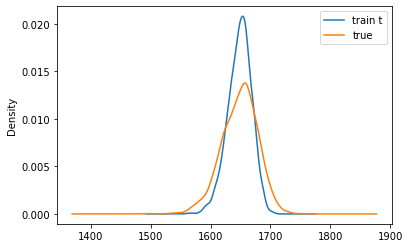


 Распределения истинных и предсказанных данных T на тесте


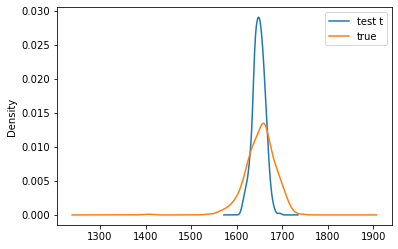


 Распределения истинных и предсказанных данных C на трейне


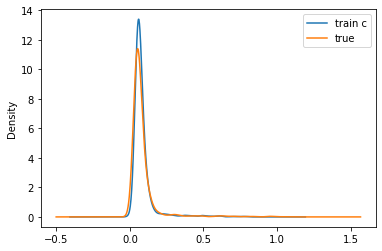


 Распределения истинных и предсказанных данных C на тесте


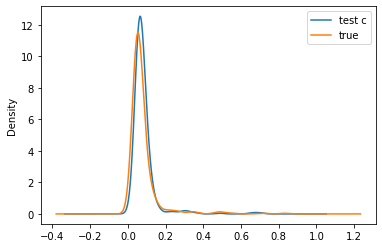

In [507]:
X_train, X_valid = train_test_split(
    target_train_1.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), train_size=0.8, random_state=1)
    
y_train_t, y_valid_t = train_test_split(
    target_train_1['TST'], train_size=0.8, random_state=1)
    
y_train_c, y_valid_c = train_test_split(
    target_train_1['C'], train_size=0.8, random_state=1)

y_train_true_c, y_valid_true_c = train_test_split(
    target_train['C'], train_size=0.8, random_state=1)

y_train_true_t, y_valid_true_t = train_test_split(
    target_train['TST'], train_size=0.8, random_state=1)

model_t = lgb.LGBMRegressor(**lgb_params)
model_c = lgb.LGBMRegressor(**lgb_params)
model_t.fit(
    X=X_train, 
    y=y_train_t,
    eval_set=[(X_train, y_train_t), (X_valid, y_valid_t)],
    eval_names=["train", "test T"],
    early_stopping_rounds=1000,
    eval_metric='rmse',
    verbose=25
)
model_c.fit(
    X=X_train, 
    y=y_train_c,
    eval_set=[(X_train, y_train_c), (X_valid, y_valid_c)],
    eval_names=["train", "test C"],
    early_stopping_rounds=1000,
    eval_metric='rmse',
    verbose=25
)
# metric from https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric
# eval_metric could be taken from: https://xgboost.readthedocs.io/en/latest/parameter.html
# or  https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters

train_predictions_t, test_predictions_t = pd.DataFrame(), pd.DataFrame()
train_predictions_c, test_predictions_c = pd.DataFrame(), pd.DataFrame()

train_predictions_t = model_t.predict(X_train)
test_predictions_t = model_t.predict(X_valid)

train_predictions_c = model_c.predict(X_train)
test_predictions_c = model_c.predict(X_valid)

# график
print('\n Распределения истинных и предсказанных данных T на трейне')
ax =  pd.Series(train_predictions_t).plot.kde(label='train t')
pd.Series(y_train_t).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных T на тесте')
ax =  pd.Series(test_predictions_t).plot.kde(label='test t')
pd.Series(y_valid_t).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных C на трейне')
ax =  pd.Series(train_predictions_c).plot.kde(label='train c')
pd.Series(y_train_c).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных C на тесте')
ax =  pd.Series(test_predictions_c).plot.kde(label='test c')
pd.Series(y_valid_c).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

In [472]:
train_predictions_t = model_t.predict(X_train)
test_predictions_t = model_t.predict(X_valid)

train_predictions_c = model_c.predict(X_train)
test_predictions_c = model_c.predict(X_valid)

413

In [480]:
test_t = model_t.predict(test.drop(['DATA_ZAMERA'], axis=1))
test_c = model_c.predict(test.drop(['DATA_ZAMERA'], axis=1))

In [510]:
def metric(answers, user_csv):

    delta_c = np.abs(np.array(answers['C']) - np.array(user_csv['C']))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(answers['TST']) - np.array(user_csv['TST']))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(answers['C'])

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

metric(predictions, answers)

1.0

**Сильное переобучение**

Дата | Время | Скор на обучении | Скор на тесте | Скор на лидерборде | Место
-|-|-|-|-|-
30.10.2021 | 05:00 | 1? | 1? | 0.31153846153846154  | 24

In [508]:
answers = pd.concat([pd.Series(y_valid_true_t).rename('TST'), 
                     pd.Series(y_valid_true_c).rename('C')
                   ],
                   axis=1
                  )
answers

TST      C
1944  1684  0.037
56    1666  0.056
622   1698  0.065
555   1657  0.058
1770  1704  0.033
...    ...    ...
750   1617  0.059
508   1658  0.058
697   1611  0.045
1357  1687  0.114
872   1615  0.061

[413 rows x 2 columns]

In [509]:
predictions = pd.concat([pd.Series(y_valid_t).rename('TST'), 
                     pd.Series(y_valid_c).rename('C')
                   ],
                   axis=1
                  )
predictions

TST      C
1944  1684  0.037
56    1666  0.056
622   1698  0.065
555   1657  0.058
1770  1704  0.033
...    ...    ...
750   1617  0.059
508   1658  0.058
697   1611  0.045
1357  1687  0.114
872   1615  0.061

[413 rows x 2 columns]

In [481]:
len(test_t), len(test_c)

(780, 780)

In [482]:
test['NPLV']

0      512324
1      512327
2      512328
3      512331
4      512333
        ...  
775    513369
776    513370
777    513371
778    513372
779    513374
Name: NPLV, Length: 780, dtype: int64

In [495]:
submit = pd.concat([test['NPLV'], 
                    pd.Series(test_t).rename('TST'), 
                    pd.Series(test_c).rename('C')
                   ],
                   axis=1
                  )
submit

NPLV          TST         C
0    512324  1636.861713  0.086299
1    512327  1634.809976  0.098023
2    512328  1652.988584  0.038351
3    512331  1635.193999  0.104375
4    512333  1636.713489  0.089071
..      ...          ...       ...
775  513369  1650.904408  0.434585
776  513370  1648.267841  0.465345
777  513371  1644.120040  0.216766
778  513372  1656.315264  0.356402
779  513374  1656.746661  0.073903

[780 rows x 3 columns]

In [499]:
# получаем текущие дату и время
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# создаём путь и имя файла с датой и временем
# file_name = f'../../data/kaggle/gb_competitive_data_analysis/lgb_predictions_{now}.csv'
file_name = f'lgb_predictions_{now}.csv'
print('File name: ', file_name)

# сохраняем в csv
submit.to_csv(file_name, index=False, encoding='utf-8')
print('\n File saved to disk!')

File name:  lgb_predictions_2021-10-30_04-46-41.csv

 File saved to disk!


# Baseline 2

Добавляем chronom

In [591]:
target_train.columns

Index(['NPLV', 'TST', 'C', 'VES', 'T', 'SI', 'MN', 'S', 'P', 'CR', 'NI', 'CU',
       'V', 'TI', 'DATA_ZAMERA', 'VES_4_К', 'VES_8_О', 'VES_13_КП',
       'VES_23_ЛЧ', 'VES_61_КШС8', 'VES_20_ОК', 'VES_48_У2КШ', 'VES_49_25КШ',
       'VES_63_СК', 'VES_3_НБ', 'O2_Выпуск металла', 'O2_Додувка на C',
       'O2_Додувка на t', 'O2_Завалка лома', 'O2_Заливка чугуна',
       'O2_Нагрев лома', 'O2_Отсечка шлака', 'O2_Охл. азотом', 'O2_Повалка',
       'O2_Прерыв. выпуска', 'O2_Продувка', 'O2_Скач. шлака', 'O2_Слив шлака',
       'durat_Выпуск металла', 'durat_Додувка на C', 'durat_Додувка на t',
       'durat_Завалка лома', 'durat_Заливка чугуна', 'durat_Нагрев лома',
       'durat_Отсечка шлака', 'durat_Охл. азотом', 'durat_Повалка',
       'durat_Прерыв. выпуска', 'durat_Продувка', 'durat_Скач. шлака',
       'durat_Слив шлака'],
      dtype='object')

In [592]:
target_train_1 = target_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
target_train_1.columns

Index(['NPLV', 'TST', 'C', 'VES', 'T', 'SI', 'MN', 'S', 'P', 'CR', 'NI', 'CU',
       'V', 'TI', 'DATA_ZAMERA', 'VES_4_', 'VES_8_', 'VES_13_', 'VES_23_',
       'VES_61_8', 'VES_20_', 'VES_48_2', 'VES_49_25', 'VES_63_', 'VES_3_',
       'O2_', 'O2_C', 'O2_t', 'O2_', 'O2_', 'O2_', 'O2_', 'O2_', 'O2_', 'O2_',
       'O2_', 'O2_', 'O2_', 'durat_', 'durat_C', 'durat_t', 'durat_', 'durat_',
       'durat_', 'durat_', 'durat_', 'durat_', 'durat_', 'durat_', 'durat_',
       'durat_'],
      dtype='object')

Training until validation scores don't improve for 1000 rounds
[25]	train's rmse: 15.3282	train's l2: 234.952	test T's rmse: 23.8	test T's l2: 566.441
[50]	train's rmse: 11.6577	train's l2: 135.902	test T's rmse: 23.4572	test T's l2: 550.238
[75]	train's rmse: 9.28032	train's l2: 86.1244	test T's rmse: 23.4503	test T's l2: 549.916
[100]	train's rmse: 7.49292	train's l2: 56.1439	test T's rmse: 23.4667	test T's l2: 550.687
Did not meet early stopping. Best iteration is:
[100]	train's rmse: 7.49292	train's l2: 56.1439	test T's rmse: 23.4667	test T's l2: 550.687
Training until validation scores don't improve for 1000 rounds
[25]	train's rmse: 0.0536505	train's l2: 0.00287838	test C's rmse: 0.0576571	test C's l2: 0.00332434
[50]	train's rmse: 0.042047	train's l2: 0.00176795	test C's rmse: 0.0589483	test C's l2: 0.0034749
[75]	train's rmse: 0.0349221	train's l2: 0.00121955	test C's rmse: 0.0596562	test C's l2: 0.00355886
[100]	train's rmse: 0.0295007	train's l2: 0.00087029	test C's rmse: 0.0

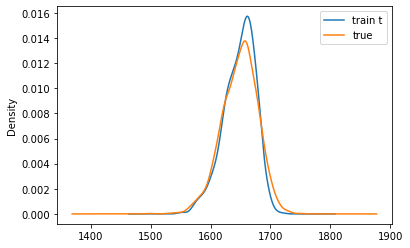


 Распределения истинных и предсказанных данных T на тесте


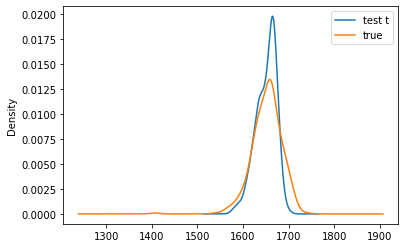


 Распределения истинных и предсказанных данных C на трейне


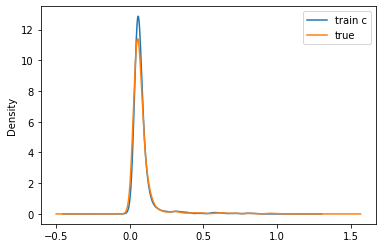


 Распределения истинных и предсказанных данных C на тесте


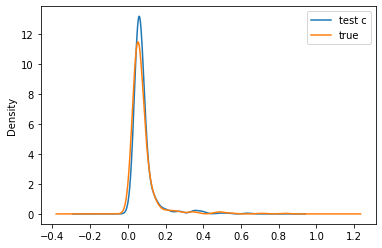

In [593]:
X_train, X_valid = train_test_split(
    target_train_1.drop(['TST', 'C', 'DATA_ZAMERA'], axis=1), train_size=0.8, random_state=1)
    
y_train_t, y_valid_t = train_test_split(
    target_train_1['TST'], train_size=0.8, random_state=1)
    
y_train_c, y_valid_c = train_test_split(
    target_train_1['C'], train_size=0.8, random_state=1)

y_train_true_c, y_valid_true_c = train_test_split(
    target_train['C'], train_size=0.8, random_state=1)

y_train_true_t, y_valid_true_t = train_test_split(
    target_train['TST'], train_size=0.8, random_state=1)

model_t = lgb.LGBMRegressor(**lgb_params)
model_c = lgb.LGBMRegressor(**lgb_params)
model_t.fit(
    X=X_train, 
    y=y_train_t,
    eval_set=[(X_train, y_train_t), (X_valid, y_valid_t)],
    eval_names=["train", "test T"],
    early_stopping_rounds=1000,
    eval_metric='rmse',
    verbose=25
)
model_c.fit(
    X=X_train, 
    y=y_train_c,
    eval_set=[(X_train, y_train_c), (X_valid, y_valid_c)],
    eval_names=["train", "test C"],
    early_stopping_rounds=1000,
    eval_metric='rmse',
    verbose=25
)
# metric from https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric
# eval_metric could be taken from: https://xgboost.readthedocs.io/en/latest/parameter.html
# or  https://xgboost.readthedocs.io/en/latest/parameter.html#learning-task-parameters

train_predictions_t, test_predictions_t = pd.DataFrame(), pd.DataFrame()
train_predictions_c, test_predictions_c = pd.DataFrame(), pd.DataFrame()

train_predictions_t = model_t.predict(X_train)
test_predictions_t = model_t.predict(X_valid)

train_predictions_c = model_c.predict(X_train)
test_predictions_c = model_c.predict(X_valid)

# график
print('\n Распределения истинных и предсказанных данных T на трейне')
ax =  pd.Series(train_predictions_t).plot.kde(label='train t')
pd.Series(y_train_t).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных T на тесте')
ax =  pd.Series(test_predictions_t).plot.kde(label='test t')
pd.Series(y_valid_t).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных C на трейне')
ax =  pd.Series(train_predictions_c).plot.kde(label='train c')
pd.Series(y_train_c).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

# график
print('\n Распределения истинных и предсказанных данных C на тесте')
ax =  pd.Series(test_predictions_c).plot.kde(label='test c')
pd.Series(y_valid_c).plot.kde(ax=ax, label='true')
plt.legend()
plt.show();

In [594]:
train_predictions_t = model_t.predict(X_train)
test_predictions_t = model_t.predict(X_valid)

train_predictions_c = model_c.predict(X_train)
test_predictions_c = model_c.predict(X_valid)

In [595]:
test_t = model_t.predict(test.drop(['DATA_ZAMERA'], axis=1))
test_c = model_c.predict(test.drop(['DATA_ZAMERA'], axis=1))

In [598]:
answers = pd.concat([pd.Series(y_valid_true_t).rename('TST'), 
                     pd.Series(y_valid_true_c).rename('C')
                   ],
                   axis=1
                  )
answers.head(2)

TST      C
1944  1684  0.037
56    1666  0.056

In [599]:
predictions = pd.concat([pd.Series(y_valid_t).rename('TST'), 
                     pd.Series(y_valid_c).rename('C')
                   ],
                   axis=1
                  )
predictions.head(2)

TST      C
1944  1684  0.037
56    1666  0.056

In [600]:
def metric(answers, user_csv):

    delta_c = np.abs(np.array(answers['C']) - np.array(user_csv['C']))
    hit_rate_c = np.int64(delta_c < 0.02)

    delta_t = np.abs(np.array(answers['TST']) - np.array(user_csv['TST']))
    hit_rate_t = np.int64(delta_t < 20)

    N = np.size(answers['C'])

    return np.sum(hit_rate_c + hit_rate_t) / 2 / N

metric(predictions, answers)

1.0

In [601]:
submit = pd.concat([test['NPLV'], 
                    pd.Series(test_t).rename('TST'), 
                    pd.Series(test_c).rename('C')
                   ],
                   axis=1
                  )
submit.head(2)

NPLV          TST         C
0  512324  1658.450485  0.057486
1  512327  1656.708173  0.047649

In [602]:
# получаем текущие дату и время
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# создаём путь и имя файла с датой и временем
# file_name = f'../../data/kaggle/gb_competitive_data_analysis/lgb_predictions_{now}.csv'
file_name = f'lgb_predictions_{now}.csv'
print('File name: ', file_name)

# сохраняем в csv
submit.to_csv(file_name, index=False, encoding='utf-8')
print('\n File saved to disk!')

File name:  lgb_predictions_2021-10-30_13-47-44.csv

 File saved to disk!
